In [1]:
import sys, os
from time import sleep, time
import numpy as np
codebase_dir = 'D:/ZiaLab/Codebase/'
sys.path.append(codebase_dir)
%reload_ext autoreload
%autoreload 2
%load_ext autotime
from zialab.misc.sugar import send_message
from zialab.misc.sugar import ding
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pickle
data_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data'
confocal_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/'
from zialab.instruments.pipython import GCSDevice
from zialab.instruments.pipython import pitools
from zialab.instruments import picoharp
from zialab.misc.sugar import send_message, send_image, post_message_to_slack, post_file_to_slack
from collections import OrderedDict
from tenacity import retry, stop_after_attempt
from zialab.instruments.confocal import *
graphs_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Graphs/'
from zialab.instruments import rotationstage
from zialab.instruments.remoteVerdi import RemoteVerdi

time: 1.75 s (started: 2022-03-04 10:10:24 -05:00)


# Initialize instruments

In [2]:
stage = GCSDevice('C-867')
stage.InterfaceSetupDlg()
stage.qIDN()
# turn on the servo motors
stage.SVO('2',True)
stage.SVO('1',True)
# configure data tables
stage.DRC(1, '1', 44) # time stamps in ms
stage.DRC(2, '1', 1) # motor output
stage.DRC(3, '1', 2) # commanded position
stage.DRC(4, '1', 73) # actual position
stage.RTR(2) # this trigger rate is adequate for the speeds and lenghts i often care about

time: 6.98 s (started: 2022-03-04 10:10:35 -05:00)


In [3]:
pharp = picoharp.PicoHarp300()
pharp.open(mode='T2')

PicoHarp300:
Picoharp device found with device index of 0.
Initializing...
Picoharp successfully intialized in T2 mode.

time: 3.77 s (started: 2022-03-02 12:08:11 -05:00)


In [152]:
pharp.open(mode='T2')

PicoHarp300:
Picoharp device found with device index of 0.
Initializing...
Picoharp successfully intialized in T2 mode.

time: 3.75 s (started: 2022-03-03 10:37:20 -05:00)


In [3]:
laser = RemoteVerdi()

time: 0 ns (started: 2022-03-04 10:10:47 -05:00)


In [5]:
# polarizer = rotationstage.PRM1Z8()
# polarizer.open()

time: 0 ns (started: 2022-03-02 12:08:15 -05:00)


## Functions (moved to confocal.py)

In [12]:
# def navigation_matrix(n1,m1,n2,m2,x1,y1,x2,y2):
#     return np.matrix([[-(-m2 * x1 + m1 * x2)/(m2*n1 - m1*n2),-(n2*x1 - n1*x2)/(m2*n1 - m1*n2)],
#             [-(-m2*y1+m1*y2)/(m2*n1-m1*n2),-(-n2*y1 + n1*y2)/(-m2*n1+m1*n2)]])
# def parse_num_coords(str_coord):
#     letters = {c: idx for idx, c in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwx')}
#     letter = re.findall('(\D)',str_coord)[0]
#     nums = ''.join(re.findall('(\d)',str_coord))
#     return np.array([int(nums),letters[letter]])
# def go_to(regionstr):
#     print("going to %s" % regionstr)
#     target = np.array(np.array([x0,y0])+navi@( parse_num_coords(regionstr)-parse_num_coords('q29')))[0]
#     move_and_wait('1',target[0])
#     move_and_wait('2',target[1])
#     x0, y0 = -1.8300, -4.5030

time: 78 ms (started: 2022-02-23 14:20:50 -05:00)


In [47]:
# def move_and_wait(axis, position):
#     '''
#     Move to the commanded position and wait until it's reached.
#     Parameters
#     ----------
#     axis  (str): 'x' or 'y'
#     position (float): position in mm
#     '''
#     assert axis in ['x','y']
#     axis = {'x':'1','y':'2'}[axis]
#     assert type(position) in [int,float,np.float64, np.float32, np.int32, np.int64], "wacky position"
#     assert abs(position) < AXES_RANGE, "position out of range"
#     stage.MOV(axis,position)
#     while not stage.qONT()[axis]:
#         sleep(0.01)

time: 78 ms (started: 2022-02-23 14:42:38 -05:00)


In [48]:
# def TRO(tro_state):
#     if tro_state.lower() == 'off':
#         stage.GcsCommandset('TRO 1 0')
#         stage.GcsCommandset('TRO 2 0')
#     if tro_state.lower() == 'ON':
#         stage.GcsCommandset('TRO 1 1')
#         stage.GcsCommandset('TRO 2 1')
# def setCTO(StartThreshold, StopThreshold, velocity, TriggerStep, Axis='1', Polarity=1, TriggerMode=0):  # Configure the CTO
#     stage.GcsCommandset('TRO 2 1')
#     stage.GcsCommandset('CTO 2 1 ' + str(TriggerStep))
#     stage.GcsCommandset('CTO 2 2 ' + Axis)
#     stage.GcsCommandset('CTO 2 3 ' + str(TriggerMode))
#     stage.GcsCommandset('CTO 2 8 ' + str(StartThreshold))
#     stage.GcsCommandset('CTO 2 9 ' + str(StopThreshold))
#     stage.GcsCommandset('CTO 2 10 ' + str(StartThreshold))
#     stage.GcsCommandset('VEL x ' + str(velocity))
#     stage.GcsCommandset('VEL y ' + str(velocity))

time: 78 ms (started: 2022-02-23 14:42:38 -05:00)


In [49]:
# def parse_events(events):
#     T3WRAPAROUND = 65536
#     parsed_events = []
#     oflcorrection = 0
#     truensync = 0
#     for event in events:
#         record = '{0:0{1}b}'.format(event,32)
#         channel = int(record[:4],base=2)
#         dtime = int(record[4:16], base=2)
#         nsync = int(record[16:], base=2)
#         if channel == 0xF:
#             if dtime == 0:
#                 oflcorrection += T3WRAPAROUND
#             else:
#                 truensync = oflcorrection + nsync
#         else:
#             truensync = oflcorrection + nsync
#         parsed_events.append([channel, dtime, nsync, truensync])
#     return parsed_events

# def parse_T2_events(events):
#     parsed_events = []
#     T2WRAPAROUND = 210698240
#     oflcorrection=0
#     truetime=0
#     for event in events:
#         record = '{0:0{1}b}'.format(event,32)
#         channel = int(record[:4],base=2)
#         time = int(record[4:],base=2)
#         if channel == 15:
#             marker = int(record[28:32], base=2)
#             if marker == 0:
#                 oflcorrection += T2WRAPAROUND
#             else:
#                 truetime = oflcorrection + time
#                 parsed_events.append([2,truetime])
#         else:
#             truetime = oflcorrection + time
#             parsed_events.append([channel,truetime])
#     parsed_events = np.array(parsed_events)
#     return parsed_events

time: 78 ms (started: 2022-02-23 14:42:38 -05:00)


In [50]:
# def snr_to_vel(scan):
#     '''
#     Using the current count rate, the trigger step,
#     an assumed noise rate, and a target SNR, the required
#     speed is returned. If the calculated speed is greater
#     that the set maximum speed, then the maximum speed is
#     returned.
#     '''
#     MAX_vel = 0.5 # in mm/s
#     target_vel = (np.sqrt(scan['dx']) * (scan['cr'] - scan['nr'])/np.sqrt(scan['cr'] + scan['nr']) / scan['SNR'])**2
#     if target_vel > MAX_vel:
#         snr = np.sqrt(scan['dx']/MAX_vel) * (scan['cr']-scan['nr'])/np.sqrt(scan['cr']+scan['nr'])
#         print("target_vel larger than max, SNR changed to %f" % snr)
#         return MAX_vel
#     else:
#         return target_vel

# def compute_runway(vel, fast=False, tol=0.001):
#     if (not fast) or (vel < 0.00125) or (vel > 0.8):
#         stage.DRT(0,1,'1')
#         d = 0.1 # move 100 um
#         current_x = stage.qPOS()['1']
#         original_vel = stage.qVEL()['1']
#         stage.VEL('1',vel)
#         move_and_wait('1',current_x+d)
#         # read the data tables
#         stage.qDRR()
#         while not stage.bufstate:
#             sleep(0.1)
#             pass
#         stage.VEL('1',original_vel)
#         times = np.array(stage.bufdata[0])
#         times = times-times[0]
#         commanded = np.array(stage.bufdata[1])
#         actual = np.array(stage.bufdata[2])
#         err = np.abs(np.abs(commanded-actual))
#         maxerrarg = np.argmax(err)
#         err = err[maxerrarg:]
#         errtimes = times[maxerrarg:]
#         erractual = actual[maxerrarg:]
#         for idx, oneerr in enumerate(err):
#             if oneerr < 0.001:
#                 break
#         goodtimearg = idx
#         goodrunway = np.abs(erractual[goodtimearg] - current_x)
#         stage.DRT(0,1,'0')
#         return goodrunway
#     else:
#         # interpolate using precomputed values
#         vels = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
#         runways = np.array([0.00230,0.00370,0.00600,
#                             0.00940,0.01570,0.02740,0.05860])
#         return np.interp(vel,vels,runways)

time: 78 ms (started: 2022-02-23 14:42:39 -05:00)


In [51]:
# def linescanner(linescan, verbose=False):
#     linescan['reads'] = [] # in this list the events will be collected
#     linescan['xf'] = (linescan['xi'] 
#             + np.ceil((linescan['xf']-linescan['xi'])
#                       /linescan['dx'])*linescan['dx'])
#     linescan['N'] = int(round(((linescan['xf']-linescan['xi'])
#                               /linescan['dx']))+1)
#     linescan['ts'] = ((linescan['xf']-linescan['xi']+2*linescan['e'])
#                       /linescan['velx'])
#     linescan['dt'] = 0.25*linescan['ts'] # how often the buffer will be read
#     linescan['tph'] = 1.2*linescan['ts'] # measurement time for picoharp
#     linescan['start'] = linescan['xi'] - linescan['e']
#     linescan['end'] = linescan['xf'] + linescan['e']
#     linescan['dwell_time'] = linescan['dx'] / linescan['velx']
#     if verbose:
#         print('Scan will take about {ts} s.'.format(**linescan))

#     # move to start at speed vsafe
#     stage.VEL('1',linescan['vsafe'])
#     stage.VEL('2',linescan['vsafe'])
#     move_and_wait('1',linescan['start'])
#     move_and_wait('2',linescan['y'])
#     # configure CTO and set speed
#     stage.VEL('1',linescan['velx'])
#     setCTO(**{'StartThreshold':linescan['xi'],
#                     'StopThreshold':linescan['xf'],
#                     'velocity':linescan['velx'],
#                     'TriggerStep':linescan['dx']})
#     # start measurement on picoharp
#     pharp.start_measurement(linescan['tph'])
#     # issue the motion command to the stage
#     try:
#         stage.MOV('1', linescan['end'])
#     except:
#         stage.MOV('1', linescan['end'])
#     # read buffer in a loop and stop when stage arrives to end
#     while True:
#         sleep(linescan['dt'])
#         buff = pharp.buffer_read()
#         if buff != None:
#             if verbose:
#                 print('adding events ...')
#             linescan['reads'].extend(list(buff))
#         if stage.qONT()['1']:
#             break
#     for idx in range(10):
#         if verbose:
#             print(idx)
#         buff = pharp.buffer_read()
#         if buff != None:
#             if verbose:
#                 print('adding events ...')
#             linescan['reads'].extend(list(buff))
#     pharp.stop_measurement()
#     linescan['events'] = np.array(parse_events(linescan['reads']))
#     linescan['parsed_scan'] = np.diff(linescan['events'][linescan['events'][:,1] == 8][:,3])/linescan['dwell_time']/1000
#     linescan['x_coords'] = np.linspace(linescan['xi'],linescan['xf'],len(linescan['parsed_scan']))
#     TRO("off")
#     return linescan

time: 78 ms (started: 2022-02-23 14:42:39 -05:00)


In [52]:
# def scanner(scan):
#     '''
#     Do a raster scan on a given region by performing a sequence of line scans.
#     If cleaning_run is True then the scan begins by moving both axes 2mm
#     in each direction, this helps greatly in improving the reliability of
#     the resulting scan. This run is done at speed v_cleaning.
    
#     If a scanning speed velx is given then this speed is used,
#     if not then it is computed with the target SNR according to the
#     count rate at the staring position. 
    
#     When returning to the left margin after having scanned a row, the
#     stage returns there moving at a speed v_safe.
    
#     Every linescan begins has a runway length computed by the functtion
#     compute_runway which is a function of the scan speed.
#     '''
#     # works consistently in a on scanning regions larger that about 20 um
#     # scans every row left to right
#     # and goes from bottom to top
#     assert scan['yf'] > scan['yi'], "yf must be larger than yi"
#     assert scan['xf'] > scan['xi'], "xf must be larger than xi"
#     scan['yf'] = (scan['yi'] 
#                   + np.ceil((scan['yf']-scan['yi'])/scan['dx'])*scan['dx'])
#     scan['Ny'] = int(round((scan['yf']-scan['yi'])/scan['dx']))
#     scan['ys'] = np.linspace(scan['yi'],scan['yf'],scan['Ny'])
#     if scan['cleaning_run']:
#         print("Running a cleaning run ...")
#         stage.VEL('1',scan['v_cleaning'])
#         stage.VEL('2',scan['v_cleaning'])
#         move_and_wait('2',scan['yi'])
#         move_and_wait('1',scan['xi'])
#         move_and_wait('1',scan['xi']-2)
#         move_and_wait('1',scan['xi']+2)
#         move_and_wait('2',scan['yi']-2)
#         move_and_wait('2',scan['yi']+2)
#     move_and_wait('2',scan['yi'])
#     move_and_wait('1',scan['xi'])
#     scan['start_time'] = time()
#     print("Reading the countrate in the starting position...")
#     scan['cr'] = pharp.get_counts()[0]
#     if 'velx' not in scan.keys():
#         print("Computing speed from given target SNR...")
#         scan['velx'] = snr_to_vel(scan)
#     scan['SNR'] = (np.sqrt(scan['dx']/scan['velx']) 
#                    * (scan['cr']-scan['nr'])/np.sqrt(scan['cr']+scan['nr']))
#     stage.VEL('2',scan['velx'])
#     if scan['fast_runway']:
#         scan['e'] = compute_runway(scan['velx'], fast=True)
#     else:
#         scan['e'] = compute_runway(scan['velx'], fast=False)
#     print("Doing linescans...")
#     for idx, y in enumerate(scan['ys']):
#         print('row %d of %d' % (idx+1, len(scan['ys'])))
#         move_and_wait('2',y)
#         linescan = {'velx': scan['velx'],
#                'e': scan['e'],
#                'xi': scan['xi'],
#                'xf': scan['xf'],
#                'dx': scan['dx'], # trigger step
#                'vsafe': scan['vsafe'],
#                'y': y,
#                'nr': scan['nr'],
#                'SNR': scan['SNR']}
#         linescan = linescanner(linescan)
#         scan['linescans'].append(linescan)
#         elapsed_time = time() - scan['start_time']
#         rem_time = (scan['Ny']-idx+1)*elapsed_time/(idx+1)/60.
#         print('Time remaining: %.1f min' % rem_time)
    
#     print("Computing final scan result...")
#     rows = [onescan['parsed_scan'] for onescan in scan['linescans']]
#     expectedcols = [(s['N']) for s in scan['linescans']]
#     colsizes = list(map(len,rows))
#     if min(colsizes) != max(colsizes): # if all is good leave as is
#         # if not then do some interpolation to put everything in shape
#         print("Probable jitter motion detected, using heuristic parsing...")
#         colsize = np.median(colsizes)
#         x_coords = np.linspace(scan['xi'],scan['xf'],int(colsize))
#         interprows = [np.interp(x_coords,
#                                 np.linspace(scan['xi'],scan['xf'],len(row)),
#                                 row) for row in rows]
#         scan['final_map'] = np.array(interprows)
#     else:
#         print("All rows good...")
#         scan['final_map'] = np.array(rows)
    
#     print("Tidying things up...")
#     scan['xf'] = linescan['xf'] # propagate the adjusted xf to scan
#     scan['time_taken'] = time() - scan['start_time']
#     scan['mins_taken'] = scan['time_taken']/60.
#     scan['dx_in_um'] = scan['dx']*1000
#     scan['info_title'] = '{sample_name}\nv = {velx:.2f} mm/s | SNR -> {SNR:.1f} | {mins_taken:.2f} min | dx = {dx_in_um} um'.format(**scan)
#     return scan 

time: 78 ms (started: 2022-02-23 14:42:40 -05:00)


In [53]:
# def linescan_retry_alert(retry_state):
#     alert_msg = 'Failure detected in linescan, retrying...'
#     send_message(alert_msg)
# @retry(stop=stop_after_attempt(3),
#       after=linescan_retry_alert)
# def T2linescanner(linescan, verbose=False):
#     linescan['reads'] = [] # in this list the events will be collected
#     linescan['xf'] = (linescan['xi'] 
#             + np.ceil((linescan['xf_original']-linescan['xi'])
#                       /linescan['dx'])*linescan['dx'])
#     linescan['N'] = int(round(((linescan['xf']-linescan['xi'])
#                               /linescan['dx']))+1)
#     linescan['ts'] = ((linescan['xf']-linescan['xi']+2*linescan['e'])
#                       /linescan['velx'])
#     linescan['dt'] = 0.25*linescan['ts'] # how often the buffer will be read
#     linescan['tph'] = 1.2*linescan['ts'] # measurement time for picoharp
#     linescan['start'] = linescan['xi'] - linescan['e']
#     linescan['end'] = linescan['xf'] + linescan['e']
#     linescan['dwell_time'] = linescan['dx'] / linescan['velx']
#     if verbose:
#         print('Scan will take about {ts} s.'.format(**linescan))

#     # move to start at speed vsafe
#     stage.VEL('1',linescan['vsafe'])
#     stage.VEL('2',linescan['vsafe'])
#     move_and_wait('1',linescan['start'])
#     move_and_wait('2',linescan['y'])
#     # configure CTO and set speed
#     stage.VEL('1',linescan['velx'])
#     setCTO(**{'StartThreshold':linescan['xi'],
#                     'StopThreshold':linescan['xf'],
#                     'velocity':linescan['velx'],
#                     'TriggerStep':linescan['dx']})
#     # start measurement on picoharp
#     pharp.start_measurement(linescan['tph'])
#     # enable data recorder on the stage
#     try:
#         stage.DRT(0,1,'1')
#     except:
#         stage.DRT(0,1,'1')
#     # issue the motion command to the stage
#     try:
#         stage.MOV('1', linescan['end'])
#     except:
#         stage.MOV('1', linescan['end'])
#     # read buffer in a loop and stop when stage arrives to end
#     while True:
#         sleep(linescan['dt'])
#         buff = pharp.buffer_read()
#         if buff != None:
#             if verbose:
#                 print('adding events ...')
#             linescan['reads'].extend(list(buff))
#         if stage.qONT()['1']:
#             break
#     for idx in range(10):
#         if verbose:
#             print(idx)
#         buff = pharp.buffer_read()
#         if buff != None:
#             if verbose:
#                 print('adding events ...')
#             linescan['reads'].extend(list(buff))
#     pharp.stop_measurement()
#     # read the data tables on the stage
#     stage.qDRR()
#     while not stage.bufstate:
#         sleep(0.1)
#         pass
#     trajectory = {}
#     trajectory['times'] = np.array(stage.bufdata[0])
#     trajectory['times'] = trajectory['times'] - trajectory['times'][0]
#     trajectory['commanded_positions'] = np.array(stage.bufdata[1])
#     trajectory['actual_positions'] = np.array(stage.bufdata[2])
#     linescan['trajectory'] = trajectory
#     stage.DRT(0,1,'0')
#     linescan['events'] = np.array(parse_T2_events(linescan['reads']))
#     linescan['numsteps'] = int((linescan['xf']-linescan['xi']+2*linescan['e'])/linescan['dx'])
#     linescan['bintimes'] = linescan['events'][linescan['events'][:,0] == 2][:,1]
#     linescan['events'] = linescan['events'][linescan['events'][:,0] != 2][:,1]
#     linescan['parsed_scan'], _, = np.histogram(linescan['events'], bins=linescan['bintimes'])
#     linescan['x_coords'] = np.linspace(linescan['xi']-linescan['e'],linescan['xf']+linescan['e'],len(linescan['parsed_scan']))
#     TRO("off")
#     return linescan

time: 62 ms (started: 2022-02-23 14:42:41 -05:00)


In [54]:
# def T2scanner_retry_alert(retry_state):
#     alert_msg = 'Failure detected in T2scanner, retrying...'
#     send_message(alert_msg)
# @retry(stop=stop_after_attempt(3),
#       after=T2scanner_retry_alert)
# def T2scanner(scan):
#     '''
#     Do a raster scan on a given region by performing a sequence of line scans.
#     If cleaning_run is True then the scan begins by moving both axes 2mm
#     in each direction, this helps greatly in improving the reliability of
#     the resulting scan. This run is done at speed v_cleaning.
    
#     If a scanning speed velx is given then this speed is used,
#     if not then it is computed with the target SNR according to the
#     count rate at the staring position. 
    
#     When returning to the left margin after having scanned a row, the
#     stage returns there moving at a speed v_safe.
    
#     Every linescan begins has a runway length computed by the functtion
#     compute_runway which is a function of the scan speed.
#     '''
#     # works consistently in a on scanning regions larger that about 20 um
#     # scans every row left to right
#     # and goes from bottom to top
#     assert scan['yf'] > scan['yi'], "yf must be larger than yi"
#     assert scan['xf'] > scan['xi'], "xf must be larger than xi"
#     scan['yf'] = (scan['yi'] 
#                   + np.ceil((scan['yf']-scan['yi'])/scan['dx'])*scan['dx'])
#     scan['Ny'] = int(round((scan['yf']-scan['yi'])/scan['dx']))
#     scan['ys'] = np.linspace(scan['yi'],scan['yf'],scan['Ny'])
#     if scan['cleaning_run']:
#         print("Running a cleaning run ...")
#         stage.VEL('1',scan['v_cleaning'])
#         stage.VEL('2',scan['v_cleaning'])
#         move_and_wait('2',scan['yi'])
#         move_and_wait('1',scan['xi'])
#         move_and_wait('1',scan['xi']-2)
#         move_and_wait('1',scan['xi']+2)
#         move_and_wait('2',scan['yi']-2)
#         move_and_wait('2',scan['yi']+2)
#     move_and_wait('2',scan['yi'])
#     move_and_wait('1',scan['xi'])
#     scan['start_time'] = time()
#     print("Reading the countrate in the starting position...")
#     scan['cr'] = pharp.get_counts()[0]
#     if 'velx' not in scan.keys():
#         print("Computing speed from given target SNR...")
#         scan['velx'] = snr_to_vel(scan)
#     scan['SNR'] = (np.sqrt(scan['dx']/scan['velx']) 
#                    * (scan['cr']-scan['nr'])/np.sqrt(scan['cr']+scan['nr']))
#     stage.VEL('2',scan['velx'])
#     if scan['fast_runway']:
#         scan['e'] = compute_runway(scan['velx'], fast=True)
#     else:
#         scan['e'] = compute_runway(scan['velx'], fast=False)
#     print("Doing linescans...")
#     scan['linescans'] = []
#     for idx, y in enumerate(scan['ys']):
#         print('row %d of %d' % (idx+1, len(scan['ys'])))
#         move_and_wait('2',y)
#         linescan = {'velx': scan['velx'],
#                'e': scan['e'],
#                'xi': scan['xi'],
#                'xf': scan['xf'],
#                'xf_original': scan['xf'],    
#                'dx': scan['dx'], # trigger step
#                'vsafe': scan['vsafe'],
#                'y': y,
#                'nr': scan['nr'],
#                'SNR': scan['SNR']}
#         linescan = T2linescanner(linescan)
#         scan['linescans'].append(linescan)
#         elapsed_time = time() - scan['start_time']
#         rem_time = (scan['Ny']-idx+1)*elapsed_time/(idx+1)/60.
#         print('Time remaining: %.1f min' % rem_time)
    
#     print("Computing final scan result with simple parsing...")
#     rows = [onescan['parsed_scan'] for onescan in scan['linescans']]
#     expectedcols = [(s['N']) for s in scan['linescans']]
#     colsizes = list(map(len,rows))
#     if min(colsizes) != max(colsizes): # if all is good leave as is
#         # if not then do some interpolation to put everything in shape
#         print("Probable jitter motion detected, using heuristic parsing...")
#         colsize = np.median(colsizes)
#         x_coords = np.linspace(scan['xi'],scan['xf'],int(colsize))
#         interprows = [np.interp(x_coords,
#                                 np.linspace(scan['xi'],scan['xf'],len(row)),
#                                 row) for row in rows]
#         scan['final_map_simple'] = np.flip(np.array(interprows),axis=1)
#     else:
#         print("All rows good...")
#         scan['final_map_simple'] = np.flip(np.array(rows), axis=1)
    
#     print("Computing final scan result with improved parsing...")
#     all_better_counts = []
#     all_dwell_times = []
#     for linescan in scan['linescans']:
#         clicks = (linescan['events'])*4./1e9
#         position_marks = (linescan['bintimes'])*4/1e9
#         position_marks = position_marks - position_marks[0]
#         stage_times =  (linescan['trajectory']['times'])
#         stage_dt = stage_times[1]-stage_times[0] # in ms
#         stage_positions = (linescan['trajectory']['actual_positions'])
#         for stage_time_pivot in stage_positions:
#             if stage_time_pivot >= linescan['xi']:
#                 break
#         stage_times = stage_times - stage_time_pivot
#         interpol_clicks = np.interp(clicks, stage_times, stage_positions)
#         linescan_marks = np.arange(linescan['xi'], linescan['xf'], linescan['dx'])
#         better_counts, _ = np.histogram(interpol_clicks, linescan_marks)
#         dwell_times, _ = np.histogram(stage_positions, bins= linescan_marks)
#         all_dwell_times.append(stage_dt*dwell_times)
#         all_better_counts.append(better_counts)
#     all_better_counts = np.flip(np.array(all_better_counts), axis=1)
#     all_dwell_times = np.flip(np.array(all_dwell_times), axis=1)
#     scan['final_map'] = all_better_counts/all_dwell_times
    
#     print("Tidying things up...")
#     scan['xf'] = linescan['xf'] # propagate the adjusted xf to scan
#     scan['time_taken'] = time() - scan['start_time']
#     scan['mins_taken'] = scan['time_taken']/60.
#     scan['dx_in_um'] = scan['dx']*1000
#     scan['info_title'] = '{sample_name}\nv = {velx:.2f} mm/s | SNR -> {SNR:.1f} | {mins_taken:.2f} min | dx = {dx_in_um} um'.format(**scan)
#     return scan 

time: 78 ms (started: 2022-02-23 14:42:41 -05:00)


In [55]:
# def navigation_matrix(n1,m1,n2,m2,x1,y1,x2,y2):
#     return np.matrix([[-(-m2 * x1 + m1 * x2)/(m2*n1 - m1*n2),-(n2*x1 - n1*x2)/(m2*n1 - m1*n2)],
#             [-(-m2*y1+m1*y2)/(m2*n1-m1*n2),-(-n2*y1 + n1*y2)/(-m2*n1+m1*n2)]])
# def parse_num_coords(str_coord):
#     letters = {c: idx for idx, c in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwx')}
#     letter = re.findall('(\D)',str_coord)[0]
#     nums = ''.join(re.findall('(\d)',str_coord))
#     return np.array([int(nums),letters[letter]])
# def go_to(regionstr):
#     print("going to %s" % regionstr)
#     target = np.array(np.array([x0,y0])+navi@( parse_num_coords(regionstr)-parse_num_coords('q29')))[0]
#     move_and_wait('1',target[0])
#     move_and_wait('2',target[1])
# x0, y0 = -1.8300, -4.5030
# n1, m1 = 2, -1
# x1, y1 = (-2.0280-x0),(-4.3980-y0)
# n2, m2 = -2, -2
# x2, y2 = (-1.6260-x0), (-4.3090-y0)
# navi = navigation_matrix(n1,m1,n2,m2,x1,y1,x2,y2)

time: 62 ms (started: 2022-02-23 14:42:42 -05:00)


## Spectra

### Loading lightfield

In [38]:
from zialab.softwarecontrol import lightfield
from zialab.softwarecontrol import spe2py

time: 0 ns (started: 2022-03-04 10:39:49 -05:00)


In [39]:
lf = lightfield.LField()
lf_dir = lf.lf_dir

time: 26.7 s (started: 2022-03-04 10:39:56 -05:00)


In [40]:
lf.pref_naming_settings()

time: 31 ms (started: 2022-03-04 10:40:31 -05:00)


In [ ]:
# lightfield.log_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/'
# lightfield.graphs_dir = '\\\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Graphs/'
# lightfield.codebase_dir = codebase_dir

time: 16 ms (started: 2022-03-04 10:15:25 -05:00)


### Acquiring spectra

In [122]:
import io

time: 0 ns (started: 2022-03-04 11:18:12 -05:00)


> Setting the nominal laser power to 100.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 700.0
>> Setting the spectrometer slit width to 20...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 8/60
> C

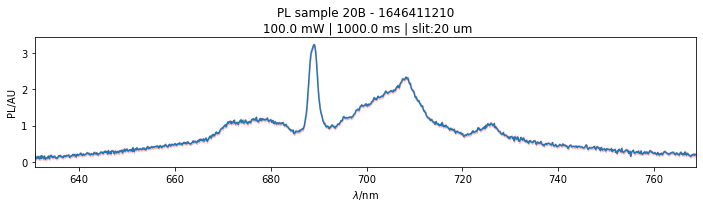

> Saving to pickle ...
time: 8min 38s (started: 2022-03-04 11:18:12 -05:00)


In [123]:
spectrum = {'sample_name': 'PL sample 20B',
        'polarization': 'unknown',
        'optics': {'obj': '60X/0.95: Olympus',
        'laser_filter':'FF01-543/22',
        'dichroic_mirror':'LPD01 532RS 25',
        'emission_filter':'LP03 532RS',
        'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 100/1000.},
        'spectra': [],
        'bkg': [],
        'exposure_time_in_ms': 1000,
        'repeats': 60,
        'center_wave': 700,
        'slit_width_in_um': 20,
        'timestamp': time()
}

laser_power = spectrum['laser']['nominal_power_in_W']
print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
laser.set_power(laser_power)
print("> Configuring the spectrograph ...")
print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
lf.set_center_wavelength(spectrum['center_wave'])
print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
lf.set_slit_width(spectrum['slit_width_in_um'])
print("> Turning off automatic background subtraction ...")
lf.background_subraction_off()
# settings for favoured naming scheme
print("> Enforcing file-naming scheme ...")
lf.pref_naming_settings()
for rep in range(spectrum['repeats']):
    print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    sleep(1)
    print("> Acquiring background data ...")
    lf.set_filename('bkg-'+spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    bkg_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['bkg'].append(bkg_data)
    print("> Opening the laser shutter ...")
    laser.set_shutter(1)
    sleep(1)
    lf.set_filename(spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    pl_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['spectra'].append(pl_data)
print("> Calculating stats ...")
time_finished = int(time())
spectrum['time_finished'] = time_finished
spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
spectrum['signals'] = np.array(spectrum['signals'])
spectrum['waves'] = spectrum['bkg'][0][0][:,0]
spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

buf = io.BytesIO()
print("> Making figure ...")
spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um' % (spectrum['sample_name'], spectrum['time_finished'],
                                     1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'])
plt.figure(figsize=(10,3))
plt.plot(spectrum['waves'], spectrum['signal_avg'])
plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
            transparent=False)
plt.savefig(buf, format='jpg')
buf.seek(0)
_ = post_file_to_slack(spectrum['info_title'],
                        spectrum['jpg_fname'],
                        buf.read(), 
                        slack_channel='#confock')
plt.show()

print("> Saving to pickle ...")
pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))



In [148]:
varney = [  [849.64, 0.022],  [834.65, 0.034],  [802.88, 0.075],  [773.45, 0.127], 
            [753.33, 0.204],  [733.14, 0.318],  [727.99, 0.42],  [725.05, 0.493], 
            [723.24, 0.467],  [718.65, 0.437],  [715.52, 0.498],  [713.72, 0.577], 
            [709.74, 0.809],  [706.67, 1.],  [704.08, 0.95],  [701.34, 0.87], 
            [699.92, 0.768],  [697.61, 0.65],  [692.99, 0.537],  [690.95, 0.589], 
            [690.11, 0.681],  [687.83, 0.753],  [686.48, 0.671],  [685.34, 0.552], 
            [682.38, 0.449],  [677.72, 0.499],  [672.31, 0.476],  [668.52, 0.403], 
            [663.85, 0.288],  [656.06, 0.246],  [649.6, 0.239] ]
varney = np.array(varney)

time: 0 ns (started: 2022-03-04 12:47:31 -05:00)


In [201]:
from scipy.signal import find_peaks

time: 0 ns (started: 2022-03-04 13:54:05 -05:00)


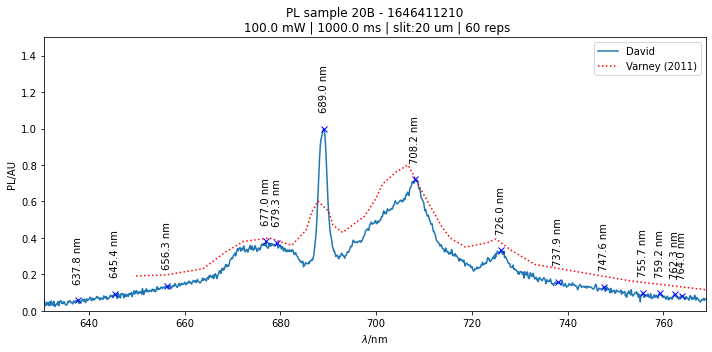

time: 422 ms (started: 2022-03-04 12:58:20 -05:00)


In [200]:
y = spectrum['signal_avg']/np.max(spectrum['signal_avg'])
peaks, _ = find_peaks(y, width=5)
plt.figure(figsize=(10,5))
plt.plot(spectrum['waves'], y, label='David')
plt.plot(varney[:,0], varney[:,1]*0.8, 'r:', label='Varney (2011)')
for peak in peaks:
    plt.plot(spectrum['waves'][peak], y[peak],'xb')
    plt.text(spectrum['waves'][peak], y[peak] + 0.1,'%.1f nm' % spectrum['waves'][peak],rotation=90, ha='center')
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'] + ' | %d reps' % spectrum['repeats'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.ylim(0,1.5)
plt.tight_layout()
plt.legend()
plt.show()

In [127]:
import h5py
with h5py.File(os.path.join(data_dir, spectrum['pkl_fname'].replace('pkl','h5')),'w') as h5file:
    h5file.create_dataset('/waves', data = spectrum['waves'])
    h5file.create_dataset('/signal', data = spectrum['signal_avg'])
h5file.close()

time: 171 ms (started: 2022-03-04 12:06:43 -05:00)


In [208]:
span = spectrum['waves'][-1]-spectrum['waves'][0]

time: 0 ns (started: 2022-03-04 13:57:11 -05:00)


In [219]:
spectrum['center_wave']-2*span

561.6984713752549

time: 0 ns (started: 2022-03-04 14:19:01 -05:00)


> Setting the nominal laser power to 100.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 838.0
>> Setting the spectrometer slit width to 20...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 8/60
> C

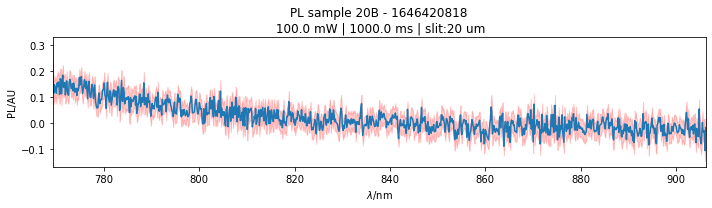

> Saving to pickle PL sample 20B - 1646420818.pkl ...
time: 8min 44s (started: 2022-03-04 13:58:16 -05:00)


In [211]:
spectrum = {'sample_name': 'PL sample 20B',
        'polarization': 'unknown',
        'optics': {'obj': '60X/0.95: Olympus',
        'laser_filter':'FF01-543/22',
        'dichroic_mirror':'LPD01 532RS 25',
        'emission_filter':'LP03 532RS',
        'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 100/1000.},
        'spectra': [],
        'bkg': [],
        'exposure_time_in_ms': 1000,
        'repeats': 60,
        'center_wave': 838,
        'slit_width_in_um': 20,
        'timestamp': time()
}

laser_power = spectrum['laser']['nominal_power_in_W']
print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
laser.set_power(laser_power)
print("> Configuring the spectrograph ...")
print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
lf.set_center_wavelength(spectrum['center_wave'])
print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
lf.set_slit_width(spectrum['slit_width_in_um'])
print("> Turning off automatic background subtraction ...")
lf.background_subraction_off()
# settings for favoured naming scheme
print("> Enforcing file-naming scheme ...")
lf.pref_naming_settings()
for rep in range(spectrum['repeats']):
    print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    sleep(1)
    print("> Acquiring background data ...")
    lf.set_filename('bkg-'+spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    bkg_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['bkg'].append(bkg_data)
    print("> Opening the laser shutter ...")
    laser.set_shutter(1)
    sleep(1)
    lf.set_filename(spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    pl_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['spectra'].append(pl_data)
print("> Calculating stats ...")
time_finished = int(time())
spectrum['time_finished'] = time_finished
spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
spectrum['signals'] = np.array(spectrum['signals'])
spectrum['waves'] = spectrum['bkg'][0][0][:,0]
spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

buf = io.BytesIO()
print("> Making figure ...")
spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um' % (spectrum['sample_name'], spectrum['time_finished'],
                                     1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'])
plt.figure(figsize=(10,3))
plt.plot(spectrum['waves'], spectrum['signal_avg'])
plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
            transparent=False)
plt.savefig(buf, format='jpg')
buf.seek(0)
_ = post_file_to_slack(spectrum['info_title'],
                        spectrum['jpg_fname'],
                        buf.read(), 
                        slack_channel='#confock')
plt.show()

print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
send_message('finished %s' % spectrum['sample_name'])



In [217]:
def send_fig(fig, slack_channel, info_msg, shortfname):
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    _ = post_file_to_slack(info_msg, shortfname, buf.read(), slack_channel=slack_channel)

time: 0 ns (started: 2022-03-04 14:18:46 -05:00)


> Setting the nominal laser power to 100.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 562.0
>> Setting the spectrometer slit width to 20...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 3/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/60
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 8/60
> C

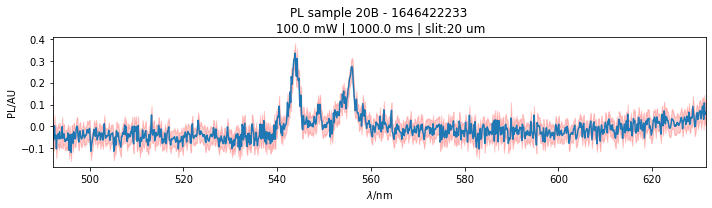

> Saving to pickle PL sample 20B - 1646422233.pkl ...
time: 8min 47s (started: 2022-03-04 14:21:47 -05:00)


In [221]:
spectrum = {'sample_name': 'PL sample 20B',
        'polarization': 'unknown',
        'optics': {'obj': '60X/0.95: Olympus',
        'laser_filter':'FF01-543/22',
        'dichroic_mirror':'LPD01 532RS 25',
        'emission_filter':'LP03 532RS',
        'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 100/1000.},
        'spectra': [],
        'bkg': [],
        'exposure_time_in_ms': 1000,
        'repeats': 60,
        'center_wave': 562,
        'slit_width_in_um': 20,
        'timestamp': time()
}

laser_power = spectrum['laser']['nominal_power_in_W']
print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
laser.set_power(laser_power)
print("> Configuring the spectrograph ...")
print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
lf.set_center_wavelength(spectrum['center_wave'])
print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
lf.set_slit_width(spectrum['slit_width_in_um'])
print("> Turning off automatic background subtraction ...")
lf.background_subraction_off()
# settings for favoured naming scheme
print("> Enforcing file-naming scheme ...")
lf.pref_naming_settings()
for rep in range(spectrum['repeats']):
    print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    sleep(1)
    print("> Acquiring background data ...")
    lf.set_filename('bkg-'+spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    bkg_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['bkg'].append(bkg_data)
    print("> Opening the laser shutter ...")
    laser.set_shutter(1)
    sleep(1)
    lf.set_filename(spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    pl_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['spectra'].append(pl_data)
print("> Calculating stats ...")
time_finished = int(time())
spectrum['time_finished'] = time_finished
spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
spectrum['signals'] = np.array(spectrum['signals'])
spectrum['waves'] = spectrum['bkg'][0][0][:,0]
spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

print("> Making figure ...")
spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um' % (spectrum['sample_name'], spectrum['time_finished'],
                                     1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'])
fig = plt.figure(figsize=(10,3))
plt.plot(spectrum['waves'], spectrum['signal_avg'])
plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
            transparent=False)
send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
plt.show()

print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
send_message('finished %s' % spectrum['sample_name'])



In [223]:
pkl_set = ['PL sample 20B - 1646422233.pkl','PL sample 20B - 1646420818.pkl','PL sample 20B - 1646411210.pkl']

time: 0 ns (started: 2022-03-04 14:33:25 -05:00)


In [236]:
import h5py
spectrum = pickle.load(open(os.path.join(data_dir, pkl_set[0]),'rb'))
with h5py.File(os.path.join(data_dir, spectrum['pkl_fname'].replace('pkl','h5')),'w') as h5file:
    h5file.create_dataset('/waves', data = spectrum['waves'])
    h5file.create_dataset('/signal', data = spectrum['signal_avg'])
h5file.close()

time: 266 ms (started: 2022-03-04 14:48:47 -05:00)


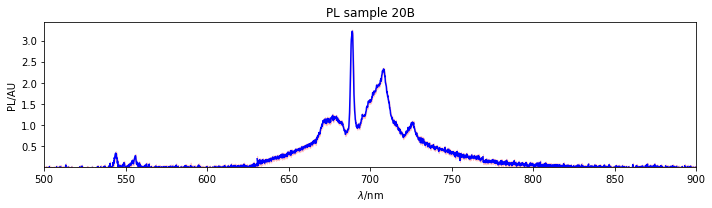

time: 2.02 s (started: 2022-03-04 14:38:46 -05:00)


In [235]:
peek = pickle.load(open(os.path.join(data_dir, pkl_set[-1]),'rb'))
fig = plt.figure(figsize=(10,3))
for pkl in pkl_set:
    spectrum = pickle.load(open(os.path.join(data_dir, pkl),'rb'))
    plt.plot(spectrum['waves'], spectrum['signal_avg'],'b-')
    plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
    spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(500,900)
# plt.yscale('log')
plt.title(spectrum['sample_name'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.ylim(bottom=1/100)
send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
plt.show()


> Setting the nominal laser power to 100.0 mW
> Configuring the spectrograph ...
>> Setting the center wavelength to 562.0
>> Setting the spectrometer slit width to 20...
> Turning off automatic background subtraction ...
> Enforcing file-naming scheme ...
Repeat 1/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 2/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Error in reply...
Retrying...
Repeat 3/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 4/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 5/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 6/150
> Closing the laser shutter
> Acquiring background data ...
> Opening the laser shutter ...
Repeat 7/150
> Closing the laser shutter
> Acquiring background data ...
> Opening 

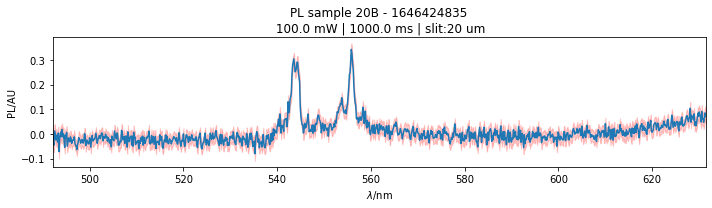

> Saving to pickle PL sample 20B - 1646424835.pkl ...
time: 21min 51s (started: 2022-03-04 14:52:06 -05:00)


In [237]:
spectrum = {'sample_name': 'PL sample 20B',
        'polarization': 'unknown',
        'optics': {'obj': '60X/0.95: Olympus',
        'laser_filter':'FF01-543/22',
        'dichroic_mirror':'LPD01 532RS 25',
        'emission_filter':'LP03 532RS',
        'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 100/1000.},
        'spectra': [],
        'bkg': [],
        'exposure_time_in_ms': 1000,
        'repeats': 150,
        'center_wave': 562,
        'slit_width_in_um': 20,
        'timestamp': time()
}

laser_power = spectrum['laser']['nominal_power_in_W']
print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
laser.set_power(laser_power)
print("> Configuring the spectrograph ...")
print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
lf.set_center_wavelength(spectrum['center_wave'])
print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
lf.set_slit_width(spectrum['slit_width_in_um'])
print("> Turning off automatic background subtraction ...")
lf.background_subraction_off()
# settings for favoured naming scheme
print("> Enforcing file-naming scheme ...")
lf.pref_naming_settings()
for rep in range(spectrum['repeats']):
    print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    sleep(1)
    print("> Acquiring background data ...")
    lf.set_filename('bkg-'+spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    bkg_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['bkg'].append(bkg_data)
    print("> Opening the laser shutter ...")
    laser.set_shutter(1)
    sleep(1)
    lf.set_filename(spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    pl_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['spectra'].append(pl_data)
print("> Calculating stats ...")
time_finished = int(time())
spectrum['time_finished'] = time_finished
spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
spectrum['signals'] = np.array(spectrum['signals'])
spectrum['waves'] = spectrum['bkg'][0][0][:,0]
spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

print("> Making figure ...")
spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um' % (spectrum['sample_name'], spectrum['time_finished'],
                                     1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'])
fig = plt.figure(figsize=(10,3))
plt.plot(spectrum['waves'], spectrum['signal_avg'])
plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
            transparent=False)
send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
plt.show()

print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
send_message('finished %s' % spectrum['sample_name'])



array([344.01355469, 588.06034061, 625.09581983, ..., 619.1060135 ,
       618.70216097, 640.61538411])

time: 16 ms (started: 2022-03-04 16:08:14 -05:00)


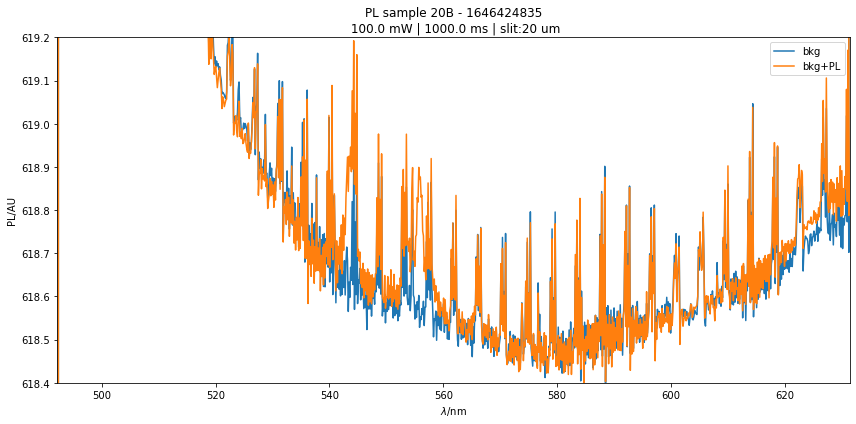

time: 375 ms (started: 2022-03-04 16:13:32 -05:00)


In [258]:
plt.figure(figsize=(12,6))
plt.plot(spectrum['waves'],np.mean([bkg[0][:,1] for bkg in spectrum['bkg']],axis=0),label='bkg')
plt.plot(spectrum['waves'],np.mean([bkg[0][:,1] for bkg in spectrum['spectra']],axis=0), label='bkg+PL')
# plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
# spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.ylim(618.4,619.2)
plt.tight_layout()
plt.legend()
# plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
#             transparent=True)
# plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
#             transparent=False)
# send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
plt.show()

In [ ]:
# in all the spectra in this section i've added an additional emission filter: 
# also, I'm using the 300g @ 500 nm grating

In [ ]:
spectrum = {'sample_name': 'PL sample 20B',
        'polarization': 'unknown',
        'optics': {'obj': '60X/0.95: Olympus',
        'laser_filter':'FF01-543/22',
        'dichroic_mirror':'LPD01 532RS 25',
        'emission_filter':'LP03 532RS',
        'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 300/1000.},
        'spectra': [],
        'bkg': [],
        'exposure_time_in_ms': 1000,
        'repeats': 150,
        'center_wave': 550,
        'slit_width_in_um': 20,
        'timestamp': time()
}

laser_power = spectrum['laser']['nominal_power_in_W']
print("> Setting the nominal laser power to %.1f mW" % (laser_power*1000))
laser.set_power(laser_power)
print("> Configuring the spectrograph ...")
print(">> Setting the center wavelength to %.1f" % spectrum['center_wave'])
lf.set_center_wavelength(spectrum['center_wave'])
print(">> Setting the spectrometer slit width to %.0f..." % spectrum['slit_width_in_um'])
lf.set_slit_width(spectrum['slit_width_in_um'])
print("> Turning off automatic background subtraction ...")
lf.background_subraction_off()
# settings for favoured naming scheme
print("> Enforcing file-naming scheme ...")
lf.pref_naming_settings()
for rep in range(spectrum['repeats']):
    print("Repeat %d/%d" % (rep+1, spectrum['repeats']))
    print("> Closing the laser shutter")
    laser.set_shutter(0)
    sleep(1)
    print("> Acquiring background data ...")
    lf.set_filename('bkg-'+spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    bkg_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['bkg'].append(bkg_data)
    print("> Opening the laser shutter ...")
    laser.set_shutter(1)
    sleep(1)
    lf.set_filename(spectrum['sample_name'])
    lf.acquire_and_wait()
    spe = lightfield.get_latest_spe_fname(lf_dir)
    pl_data = spe2py.load(spe['fname'], spe['dir'])
    spectrum['spectra'].append(pl_data)
print("> Calculating stats ...")
time_finished = int(time())
spectrum['time_finished'] = time_finished
spectrum['signals'] = [pl[0][:,1]-bkg[0][:,1] for bkg, pl in zip(spectrum['bkg'], spectrum['spectra'])]
spectrum['signals'] = np.array(spectrum['signals'])
spectrum['waves'] = spectrum['bkg'][0][0][:,0]
spectrum['signal_avg'] = np.mean(spectrum['signals'],axis=0)
spectrum['signal_std'] = np.std(spectrum['signals'],axis=0)/np.sqrt(spectrum['repeats'])

spectrum['pdf_fname'] = '%s - %d.pdf' % (spectrum['sample_name'], time_finished)
spectrum['png_fname'] = '%s - %d.png' % (spectrum['sample_name'], time_finished)
spectrum['jpg_fname'] = '%s - %d.jpg' % (spectrum['sample_name'], time_finished)
spectrum['pkl_fname'] = '%s - %d.pkl' % (spectrum['sample_name'], time_finished)

print("> Making figure ...")
spectrum['info_title'] = '%s - %s\n %.1f mW | %.1f ms | slit:%.0f um' % (spectrum['sample_name'], spectrum['time_finished'],
                                     1000*laser_power, spectrum['exposure_time_in_ms'], spectrum['slit_width_in_um'])
fig = plt.figure(figsize=(10,3))
plt.plot(spectrum['waves'], spectrum['signal_avg'])
plt.fill_between(spectrum['waves'], spectrum['signal_avg']-spectrum['signal_std'],
spectrum['signal_avg']+spectrum['signal_std'], color='r', alpha=0.2)
plt.xlim(spectrum['waves'][0],spectrum['waves'][-1])
plt.title(spectrum['info_title'])
plt.xlabel('$\lambda$/nm')
plt.ylabel('PL/AU')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,spectrum['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,spectrum['png_fname']),
            transparent=False)
send_fig(fig,'#confock', spectrum['info_title'], spectrum['jpg_fname'])
plt.show()

print("> Saving to pickle %s ..." % spectrum['pkl_fname'])
pickle.dump(spectrum, open(os.path.join(data_dir, spectrum['pkl_fname']),'wb'))
send_message('finished %s' % spectrum['sample_name'])



# Grid Scan (Mar 3) at @ microz 98

scanning 0.0 0.0
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.8 min
row 2 of 50
Time remaining: 2.0 min
row 3 of 50
Time remaining: 2.1 min
row 4 of 50
Time remaining: 2.5 min
row 5 of 50
Time remaining: 2.6 min
row 6 of 50
Time remaining: 2.8 min
row 7 of 50
Time remaining: 2.9 min
row 8 of 50
Time remaining: 2.8 min
row 9 of 50
Time remaining: 2.7 min
row 10 of 50
Time remaining: 2.6 min
row 11 of 50
Time remaining: 2.5 min
row 12 of 50
Time remaining: 2.4 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.3 min
row 15 of 50
Time remaining: 2.2 min
row 16 of 50
Time remaining: 2.2 min
row 17 of 50
Time remaining: 2.1 min
row 18 of 50
Time remaining: 2.0 min
row 19 of 50
Time remaining: 2.0 min
row 20 of 50
Time remaining: 1.9 min
row 21 of 50
Time remaining: 1.9 min
row 22 of 50
Time r

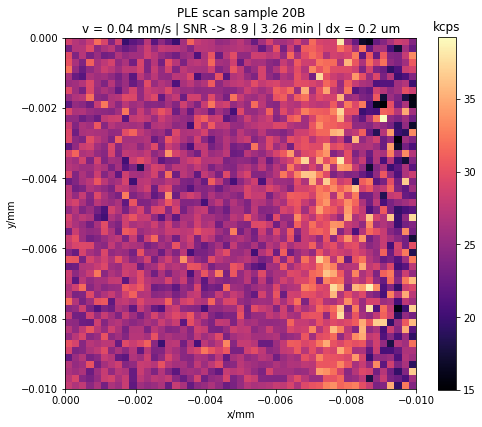

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646322304.pkl
Closing the laser shutter...
scanning 0.01 0.0
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 3.4 min
row 2 of 50
Time remaining: 2.9 min
row 3 of 50
Time remaining: 2.7 min
row 4 of 50
Time remaining: 2.9 min
row 5 of 50
Time remaining: 2.9 min
row 6 of 50
Time remaining: 2.9 min
row 7 of 50
Time remaining: 2.9 min
row 8 of 50
Time remaining: 2.9 min
row 9 of 50
Time remaining: 2.9 min
row 10 of 50
Time remaining: 2.8 min
row 11 of 50
Time remaining: 2.8 min
row 12 of 50
Time remaining: 2.7 min
row 13 of 50
Time remaining: 2.7 min
row 14 of 50
Time remaining: 2.6 min
row 15 of 50
Time remaining: 2.6 min
row 16 of 50
Time remaining: 2.5 min
row 17 of 50
Time remaining: 2.4 min
row 18 of 50
Time rem

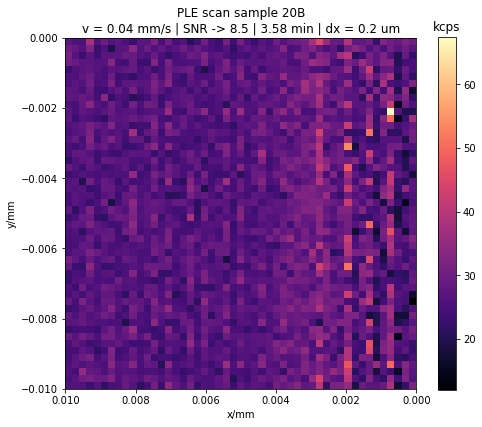

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646322578.pkl
Closing the laser shutter...
scanning 0.02 0.0
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.7 min
row 2 of 50
Time remaining: 2.0 min
row 3 of 50
Time remaining: 2.0 min
row 4 of 50
Time remaining: 2.3 min
row 5 of 50
Time remaining: 2.4 min
row 6 of 50
Time remaining: 2.5 min
row 7 of 50
Time remaining: 2.5 min
row 8 of 50
Time remaining: 2.5 min
row 9 of 50
Time remaining: 2.6 min
row 10 of 50
Time remaining: 2.6 min
row 11 of 50
Time remaining: 2.6 min
row 12 of 50
Time remaining: 2.5 min
row 13 of 50
Time remaining: 2.5 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.4 min
row 16 of 50
Time remaining: 2.4 min
row 17 of 50
Time remaining: 2.3 min
row 18 of 50
Time rem

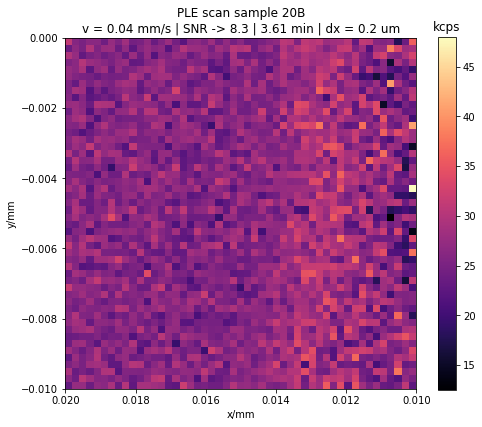

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646322853.pkl
Closing the laser shutter...
scanning 0.03 0.0
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 3.4 min
row 2 of 50
Time remaining: 2.8 min
row 3 of 50
Time remaining: 2.5 min
row 4 of 50
Time remaining: 2.6 min
row 5 of 50
Time remaining: 2.6 min
row 6 of 50
Time remaining: 2.6 min
row 7 of 50
Time remaining: 2.6 min
row 8 of 50
Time remaining: 2.6 min
row 9 of 50
Time remaining: 2.6 min
row 10 of 50
Time remaining: 2.6 min
row 11 of 50
Time remaining: 2.6 min
row 12 of 50
Time remaining: 2.5 min
row 13 of 50
Time remaining: 2.5 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.4 min
row 16 of 50
Time remaining: 2.3 min
row 17 of 50
Time remaining: 2.3 min
row 18 of 50
Time rem

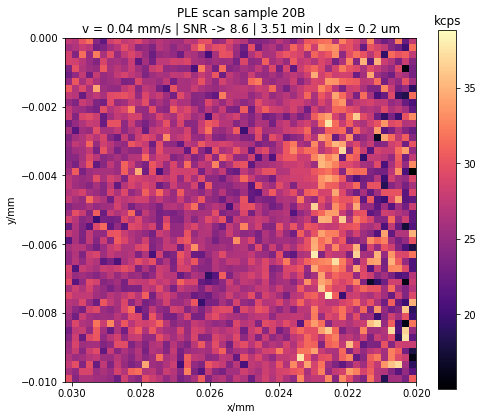

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646323122.pkl
Closing the laser shutter...
scanning 0.0 0.01
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.8 min
row 2 of 50
Time remaining: 1.6 min
row 3 of 50
Time remaining: 1.9 min
row 4 of 50
Time remaining: 2.3 min
row 5 of 50
Time remaining: 2.4 min
row 6 of 50
Time remaining: 2.5 min
row 7 of 50
Time remaining: 2.6 min
row 8 of 50
Time remaining: 2.6 min
row 9 of 50
Time remaining: 2.6 min
row 10 of 50
Time remaining: 2.6 min
row 11 of 50
Time remaining: 2.6 min
row 12 of 50
Time remaining: 2.6 min
row 13 of 50
Time remaining: 2.6 min
row 14 of 50
Time remaining: 2.5 min
row 15 of 50
Time remaining: 2.5 min
row 16 of 50
Time remaining: 2.4 min
row 17 of 50
Time remaining: 2.4 min
row 18 of 50
Time rem

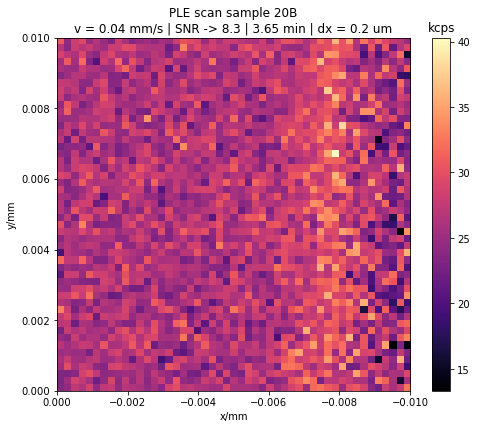

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646323400.pkl
Closing the laser shutter...
scanning 0.01 0.01
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.7 min
row 2 of 50
Time remaining: 2.1 min
row 3 of 50
Time remaining: 2.1 min
row 4 of 50
Time remaining: 2.3 min
row 5 of 50
Time remaining: 2.4 min
row 6 of 50
Time remaining: 2.5 min
row 7 of 50
Time remaining: 2.5 min
row 8 of 50
Time remaining: 2.5 min
row 9 of 50
Time remaining: 2.5 min
row 10 of 50
Time remaining: 2.5 min
row 11 of 50
Time remaining: 2.5 min
row 12 of 50
Time remaining: 2.4 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.3 min
row 16 of 50
Time remaining: 2.3 min
row 17 of 50
Time remaining: 2.2 min
row 18 of 50
Time re

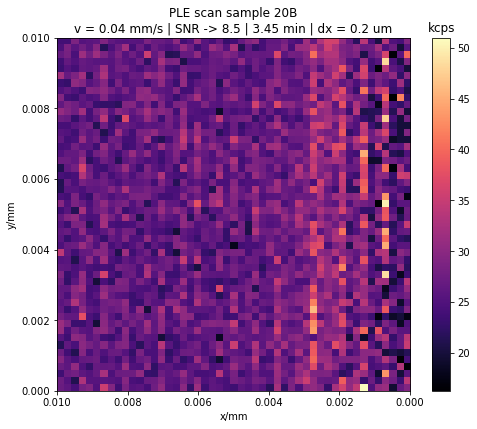

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646323666.pkl
Closing the laser shutter...
scanning 0.02 0.01
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.6 min
row 2 of 50
Time remaining: 1.5 min
row 3 of 50
Time remaining: 1.8 min
row 4 of 50
Time remaining: 2.1 min
row 5 of 50
Time remaining: 2.3 min
row 6 of 50
Time remaining: 2.3 min
row 7 of 50
Time remaining: 2.4 min
row 8 of 50
Time remaining: 2.4 min
row 9 of 50
Time remaining: 2.4 min
row 10 of 50
Time remaining: 2.4 min
row 11 of 50
Time remaining: 2.4 min
row 12 of 50
Time remaining: 2.4 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.3 min
row 15 of 50
Time remaining: 2.3 min
row 16 of 50
Time remaining: 2.2 min
row 17 of 50
Time remaining: 2.2 min
row 18 of 50
Time re

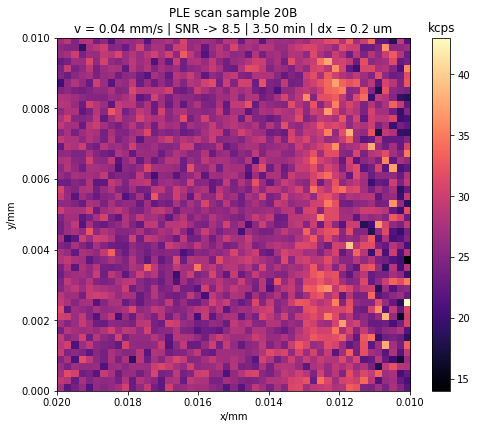

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646323936.pkl
Closing the laser shutter...
scanning 0.03 0.01
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.5 min
row 2 of 50
Time remaining: 1.8 min
row 3 of 50
Time remaining: 1.9 min
row 4 of 50
Time remaining: 2.2 min
row 5 of 50
Time remaining: 2.3 min
row 6 of 50
Time remaining: 2.4 min
row 7 of 50
Time remaining: 2.4 min
row 8 of 50
Time remaining: 2.4 min
row 9 of 50
Time remaining: 2.4 min
row 10 of 50
Time remaining: 2.5 min
row 11 of 50
Time remaining: 2.4 min
row 12 of 50
Time remaining: 2.4 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.3 min
row 15 of 50
Time remaining: 2.3 min
row 16 of 50
Time remaining: 2.2 min
row 17 of 50
Time remaining: 2.2 min
row 18 of 50
Time re

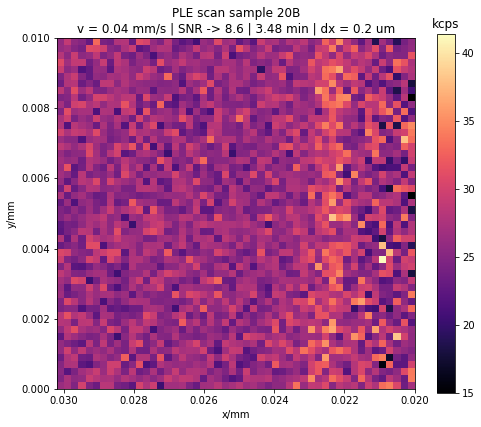

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646324204.pkl
Closing the laser shutter...
scanning 0.0 0.02
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.5 min
row 2 of 50
Time remaining: 1.5 min
row 3 of 50
Time remaining: 1.4 min
row 4 of 50
Time remaining: 1.7 min
row 5 of 50
Time remaining: 1.8 min
row 6 of 50
Time remaining: 2.0 min
row 7 of 50
Time remaining: 2.2 min
row 8 of 50
Time remaining: 2.3 min
row 9 of 50
Time remaining: 2.4 min
row 10 of 50
Time remaining: 2.4 min
row 11 of 50
Time remaining: 2.4 min
row 12 of 50
Time remaining: 2.4 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.3 min
row 16 of 50
Time remaining: 2.3 min
row 17 of 50
Time remaining: 2.3 min
row 18 of 50
Time rem

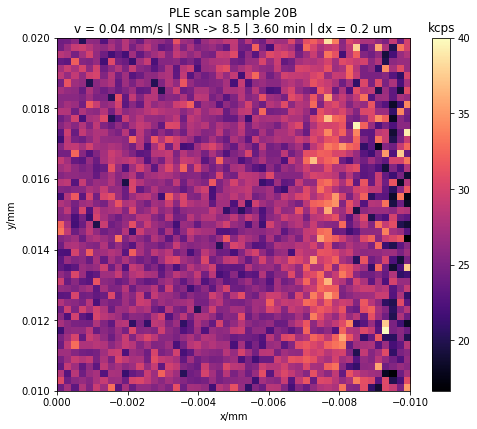

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646324480.pkl
Closing the laser shutter...
scanning 0.01 0.02
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 3.4 min
row 2 of 50
Time remaining: 3.0 min
row 3 of 50
Time remaining: 2.7 min
row 4 of 50
Time remaining: 2.8 min
row 5 of 50
Time remaining: 2.8 min
row 6 of 50
Time remaining: 2.8 min
row 7 of 50
Time remaining: 2.8 min
row 8 of 50
Time remaining: 2.8 min
row 9 of 50
Time remaining: 2.7 min
row 10 of 50
Time remaining: 2.7 min
row 11 of 50
Time remaining: 2.7 min
row 12 of 50
Time remaining: 2.6 min
row 13 of 50
Time remaining: 2.6 min
row 14 of 50
Time remaining: 2.5 min
row 15 of 50
Time remaining: 2.5 min
row 16 of 50
Time remaining: 2.4 min
row 17 of 50
Time remaining: 2.4 min
row 18 of 50
Time re

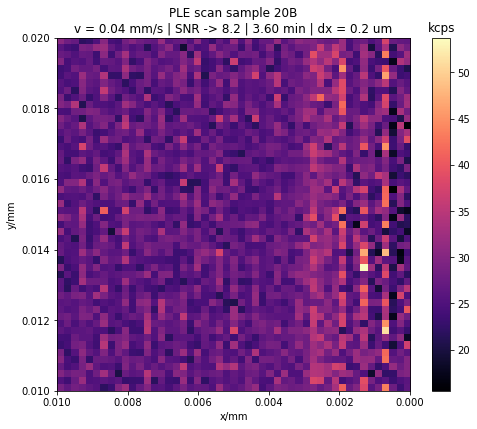

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646324756.pkl
Closing the laser shutter...
scanning 0.02 0.02
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.7 min
row 2 of 50
Time remaining: 1.5 min
row 3 of 50
Time remaining: 1.8 min
row 4 of 50
Time remaining: 2.2 min
row 5 of 50
Time remaining: 2.3 min
row 6 of 50
Time remaining: 2.4 min
row 7 of 50
Time remaining: 2.5 min
row 8 of 50
Time remaining: 2.5 min
row 9 of 50
Time remaining: 2.5 min
row 10 of 50
Time remaining: 2.5 min
row 11 of 50
Time remaining: 2.5 min
row 12 of 50
Time remaining: 2.5 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.4 min
row 16 of 50
Time remaining: 2.3 min
row 17 of 50
Time remaining: 2.3 min
row 18 of 50
Time re

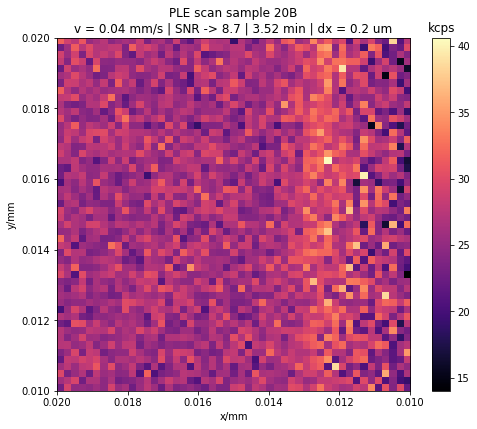

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646325026.pkl
Closing the laser shutter...
scanning 0.03 0.02
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 50
Time remaining: 1.7 min
row 2 of 50
Time remaining: 2.0 min
row 3 of 50
Time remaining: 2.1 min
row 4 of 50
Time remaining: 2.3 min
row 5 of 50
Time remaining: 2.4 min
row 6 of 50
Time remaining: 2.5 min
row 7 of 50
Time remaining: 2.5 min
row 8 of 50
Time remaining: 2.5 min
row 9 of 50
Time remaining: 2.5 min
row 10 of 50
Time remaining: 2.5 min
row 11 of 50
Time remaining: 2.5 min
row 12 of 50
Time remaining: 2.5 min
row 13 of 50
Time remaining: 2.4 min
row 14 of 50
Time remaining: 2.4 min
row 15 of 50
Time remaining: 2.4 min
row 16 of 50
Time remaining: 2.3 min
row 17 of 50
Time remaining: 2.3 min
row 18 of 50
Time re

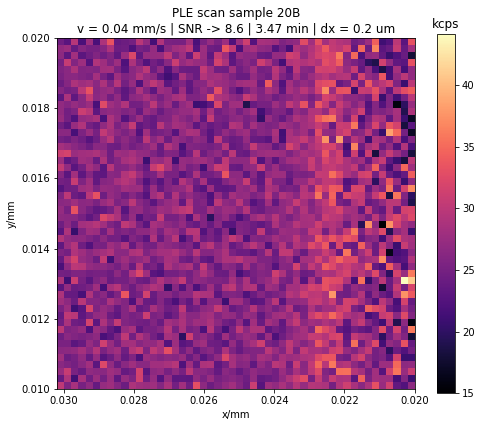

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646325293.pkl
Closing the laser shutter...
scanning 0.0 0.03
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 51
Time remaining: 1.5 min
row 2 of 51
Time remaining: 1.4 min
row 3 of 51
Time remaining: 1.4 min
row 4 of 51
Time remaining: 1.8 min
row 5 of 51
Time remaining: 1.9 min
row 6 of 51
Time remaining: 2.1 min
row 7 of 51
Time remaining: 2.3 min
row 8 of 51
Time remaining: 2.4 min
row 9 of 51
Time remaining: 2.4 min
row 10 of 51
Time remaining: 2.4 min
row 11 of 51
Time remaining: 2.4 min
row 12 of 51
Time remaining: 2.4 min
row 13 of 51
Time remaining: 2.4 min
row 14 of 51
Time remaining: 2.4 min
row 15 of 51
Time remaining: 2.3 min
row 16 of 51
Time remaining: 2.3 min
row 17 of 51
Time remaining: 2.3 min
row 18 of 51
Time rem

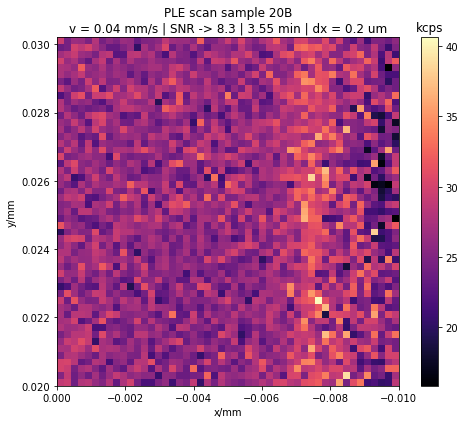

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646325565.pkl
Closing the laser shutter...
scanning 0.01 0.03
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 51
Time remaining: 3.4 min
row 2 of 51
Time remaining: 3.0 min
row 3 of 51
Time remaining: 2.7 min
row 4 of 51
Time remaining: 2.8 min
row 5 of 51
Time remaining: 2.8 min
row 6 of 51
Time remaining: 2.8 min
row 7 of 51
Time remaining: 2.8 min
row 8 of 51
Time remaining: 2.8 min
row 9 of 51
Time remaining: 2.8 min
row 10 of 51
Time remaining: 2.7 min
row 11 of 51
Time remaining: 2.7 min
row 12 of 51
Time remaining: 2.6 min
row 13 of 51
Time remaining: 2.6 min
row 14 of 51
Time remaining: 2.5 min
row 15 of 51
Time remaining: 2.5 min
row 16 of 51
Time remaining: 2.4 min
row 17 of 51
Time remaining: 2.4 min
row 18 of 51
Time re

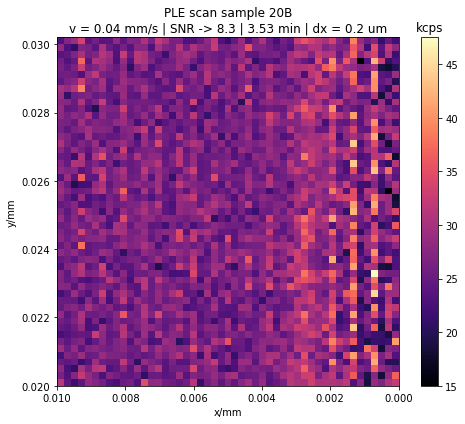

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646325836.pkl
Closing the laser shutter...
scanning 0.02 0.03
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 51
Time remaining: 1.5 min
row 2 of 51
Time remaining: 1.4 min
row 3 of 51
Time remaining: 1.7 min
row 4 of 51
Time remaining: 2.1 min
row 5 of 51
Time remaining: 2.3 min
row 6 of 51
Time remaining: 2.4 min
row 7 of 51
Time remaining: 2.4 min
row 8 of 51
Time remaining: 2.5 min
row 9 of 51
Time remaining: 2.5 min
row 10 of 51
Time remaining: 2.5 min
row 11 of 51
Time remaining: 2.5 min
row 12 of 51
Time remaining: 2.5 min
row 13 of 51
Time remaining: 2.4 min
row 14 of 51
Time remaining: 2.4 min
row 15 of 51
Time remaining: 2.4 min
row 16 of 51
Time remaining: 2.3 min
row 17 of 51
Time remaining: 2.3 min
row 18 of 51
Time re

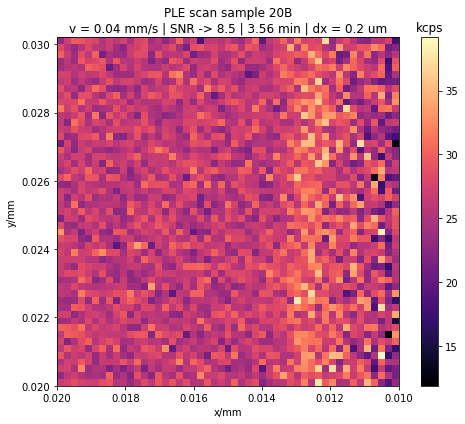

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646326108.pkl
Closing the laser shutter...
scanning 0.03 0.03
Opening the laser shutter...
Setting the laser power to 300.0 mW...
Configuring scan...
scanning...
Running a cleaning run ...
Reading the countrate in the starting position...
Doing linescans...
row 1 of 51
Time remaining: 3.5 min
row 2 of 51
Time remaining: 2.9 min
row 3 of 51
Time remaining: 2.6 min
row 4 of 51
Time remaining: 2.7 min
row 5 of 51
Time remaining: 2.8 min
row 6 of 51
Time remaining: 2.8 min
row 7 of 51
Time remaining: 2.8 min
row 8 of 51
Time remaining: 2.8 min
row 9 of 51
Time remaining: 2.8 min
row 10 of 51
Time remaining: 2.8 min
row 11 of 51
Time remaining: 2.7 min
row 12 of 51
Time remaining: 2.7 min
row 13 of 51
Time remaining: 2.6 min
row 14 of 51
Time remaining: 2.6 min
row 15 of 51
Time remaining: 2.5 min
row 16 of 51
Time remaining: 2.5 min
row 17 of 51
Time remaining: 2.4 min
row 18 of 51
Time re

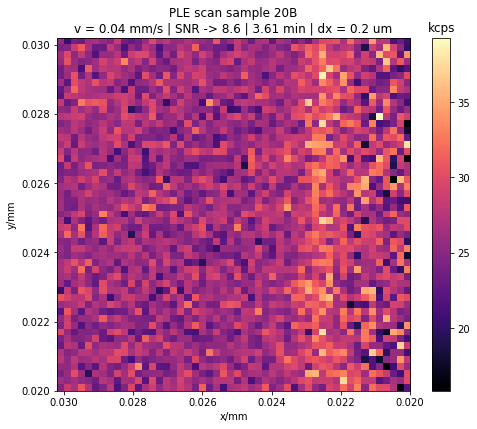

Pickling for keeps...
\\files.brown.edu/home/jlizaraz/ZiaLab/Log/Data/Confocal/PLE scan sample 20B - 1646326383.pkl
Closing the laser shutter...
PLE scan sample 20B - gridscan - 1646326388.pkl
time: 1h 12min 40s (started: 2022-03-03 10:40:52 -05:00)


In [153]:
reps = 4
d = 0.01
bigscan = {'deltaxs': [d*rep for rep in range(reps)]}
bigscan['deltays'] = bigscan['deltaxs']
bigscan['micro-z'] = 98
bigscan['reps'] = reps
bigscan['d'] = d
bigscan['scans'] = {}
d = bigscan['d']
for deltay in bigscan['deltays']:
    for deltax in bigscan['deltaxs']:
        print("scanning", deltax, deltay)
        scan_params = {'scan_name': 'PLE scan sample 20B',
                'polarization': 'unknown',
                'roi': {'xi': -d + deltax,
                        'xf': 0.000 + deltax, 
                        'yi': -d + deltay,
                        'yf': 0.000 + deltay},
                'optics': {'obj': '60X/0.95: Olympus',
                'laser_filter':'FF01-543/22',
                'dichroic_mirror':'LPD01 532RS 25',
                'emission_filter':'LP03 532RS',
                'emission_filter_2':''},
                'laser':{'wavelength': 532,
                'nominal_power_in_W': 300/1000.},
                'velx': 0.04, # may be changed by recording tables consideration
                'dx': 0.2e-3,
                'fast_runway': True,
                'vsafe': 0.2,
                'v_cleaning': 0.3,
                'nr': 150,
                'SNR': 5,
                'stage_trigger_cycles': int(4),
                'cleaning_run': True,
                'scans': []
        }
        try:
            stage.RTR(scan_params['stage_trigger_cycles'])
        except:
            print("Problem setting the trigger cycles, retrying...")
            stage.RTR(scan_params['stage_trigger_cycles'])
        scan_params['stage_record_length_in_ms'] = scan_params['stage_trigger_cycles']*50/1000.*8192

        print("Opening the laser shutter...")
        laser.set_shutter(1)
        print("Setting the laser power to %.1f mW..." % (1000*scan_params['laser']['nominal_power_in_W']))
        laser.set_power(scan_params['laser']['nominal_power_in_W'])

        roi = scan_params['roi']
        print("Configuring scan...")
        scan = {'sample_name': '%s' % (scan_params['scan_name']),
            'velx': scan_params['velx'], # in mm/s (if not given, then computed from SNR)
            'xi': roi['xi'], # in mm
            'xf': roi['xf'], # in mm
            'yi': roi['yi'], # in mm
            'yf': roi['yf'], # in mm
            'fast_runway': scan_params['fast_runway'], # this controls how the runway is calculated
            'dx': scan_params['dx'], # trigger step
            'vsafe': scan_params['vsafe'], # in mm/s; used to move to the leftmost column
            'v_cleaning': scan_params['v_cleaning'], # in mm/s; used for the cleaning run
            'nr': scan_params['nr'], # dark count rate for the photodetector
            'SNR': scan_params['SNR'], # target SNR
            'cleaning_run': scan_params['cleaning_run']}
        scan['e'] = 1.5*compute_runway(stage, scan['velx'], fast = scan_params['fast_runway'])
        # computing the estimated linescan time
        aprox_linescan_time = (scan['xf']-scan['xi']+scan['e'])/scan['velx']*1000.
        if aprox_linescan_time > 0.9*scan_params['stage_record_length_in_ms']:
            print("Record table will run short, increasing scan speed...")
            scan['velx'] = 1000*1.1*(scan['xf']-scan['xi']+scan['e']) / scan_params['stage_record_length_in_ms']

        print("scanning...")
        scan = T2scanner(stage, pharp, scan)
        time_finished = int(time())
        scan['time_finished'] = time_finished
        print("plotting...")
        scan['pdf_fname'] = '%s - %d.pdf' % (scan['sample_name'], time_finished)
        scan['png_fname'] = '%s - %d.png' % (scan['sample_name'], time_finished)
        scan['jpg_fname'] = '%s - %d.jpg' % (scan['sample_name'], time_finished)
        scan['pkl_fname'] = '%s - %d.pkl' % (scan['sample_name'], time_finished)

        buf = io.BytesIO()
        fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(7.2, 6.0))
        ims = ax1.imshow(scan['final_map'], origin='lower',
                    extent=[scan['xf'],scan['xi'],
                            scan['yi'], scan['yf']],
                    cmap='magma', interpolation='none')
        ax1.set_xlabel('x/mm')
        ax1.set_ylabel('y/mm')
        cbar = fig.colorbar(ims,ax=ax1, pad=0.05)
        cbar.ax.set_title('kcps')
        ax1.set_title(scan['info_title'])
        plt.tight_layout()
        plt.savefig(os.path.join(graphs_dir,scan['pdf_fname']),
                    transparent=True)
        plt.savefig(os.path.join(graphs_dir,scan['png_fname']),
                    transparent=False)
        plt.savefig(buf, format='jpg')
        buf.seek(0)
        _ = post_file_to_slack(scan['info_title'],
                                scan['jpg_fname'],
                                buf.read(), 
                                slack_channel='#confock')
        send_image(os.path.join(graphs_dir,scan['png_fname']), scan['png_fname'])
        plt.show()

        scan_params['scans'].append(scan)
        print("Pickling for keeps...")
        pickle.dump(scan_params,
                    open(os.path.join(confocal_dir, scan['pkl_fname']),'wb'))
        print(os.path.join(confocal_dir, scan['pkl_fname']))
        print("Closing the laser shutter...")
        laser.set_shutter(0)
        bigscan['scans'][(deltax, deltay)] = scan_params
    send_message("Big row finished.")
bigscan['time_finished'] = int(time())
bigscan['pkl_fname'] = '%s - gridscan - %d.pkl' % (scan['sample_name'], bigscan['time_finished'])
pickle.dump(bigscan, open(os.path.join(confocal_dir, bigscan['pkl_fname']),'wb'))
print(bigscan['pkl_fname'])


In [154]:
all_dwell_times = []
for linescan in bigscan['scans'][(0,0)]['scans'][0]['linescans']:
    clicks = (linescan['events'])*4./1e9
    position_marks = (linescan['bintimes'])*4/1e9
    position_marks = position_marks - position_marks[0]
    stage_times =  (linescan['trajectory']['times'])
    stage_dt = stage_times[1]-stage_times[0] # in ms
    stage_positions = (linescan['trajectory']['actual_positions'])
    for stage_time_pivot in stage_positions:
        if stage_time_pivot >= linescan['xi']:
            break
    stage_times = stage_times - stage_time_pivot
    interpol_clicks = np.interp(clicks, stage_times, stage_positions)
    linescan_marks = np.arange(linescan['xi'], linescan['xf'], linescan['dx'])
    better_counts, _ = np.histogram(interpol_clicks, linescan_marks)
    dwell_times, _ = np.histogram(stage_positions, bins= linescan_marks)
    all_dwell_times.append(stage_dt*dwell_times)
mean_dwell_in_ms = np.mean(np.array(all_dwell_times).flatten())

time: 47 ms (started: 2022-03-03 11:53:33 -05:00)


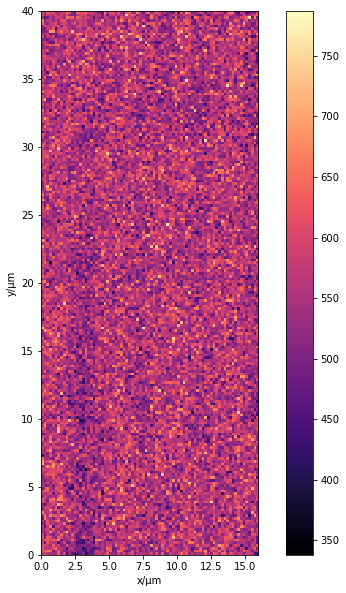

time: 328 ms (started: 2022-03-03 20:10:51 -05:00)


In [174]:
grid = []
for y_idx, deltay in enumerate(bigscan['deltays']):
    row = []
    for x_idx, deltax in enumerate(bigscan['deltaxs']):
        # if x_idx == 1:
        #     continue
        final_map = bigscan['scans'][(deltax, deltay)]['scans'][0]['final_map_simple']
        row.append(final_map[:50,:20])
    grid.append(np.concatenate(row))
grid = np.concatenate(grid,axis=1)
grid = grid*mean_dwell_in_ms
plt.figure(figsize=(10,10))
plt.imshow(grid,origin='lower',
                    extent=[0,1000*bigscan['d']*reps*20/50,
                            0,1000*bigscan['d']*reps],
                    cmap='magma', interpolation='none')
plt.xlabel('x/μm')
plt.ylabel('y/μm')
plt.colorbar()
plt.show()


In [170]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

time: 0 ns (started: 2022-03-03 20:03:05 -05:00)


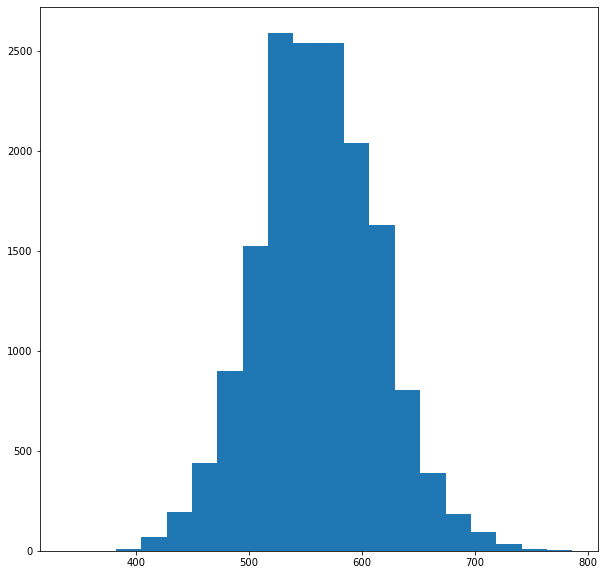

time: 188 ms (started: 2022-03-03 20:03:06 -05:00)


In [171]:
plt.figure(figsize=(10,10))
plt.hist(grid.flatten().astype(np.int32), bins=20)
plt.show()

In [172]:
# plt.figure(figsize=(10,10))
# plt.imshow(grid/4.,origin='lower',
#                     extent=[0,1000*bigscan['d']*reps,
#                             0,1000*bigscan['d']*reps],
#                     cmap='magma', interpolation='none')
# plt.xlabel('x/um')
# plt.ylabel('y/um')
# plt.colorbar()
# plt.show()

time: 0 ns (started: 2022-03-03 20:03:10 -05:00)


In [173]:
import h5py
with h5py.File(os.path.join(data_dir, 'S20B-YAG-gridscan-2-nointerpol.h5')) as h5file:
    h5file.create_dataset('griddata', data = grid.astype(np.int32))

time: 32 ms (started: 2022-03-03 20:03:11 -05:00)


<ipython-input-173-e247312423de>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(data_dir, 'S20B-YAG-gridscan-2-nointerpol.h5')) as h5file:


In [180]:
laser.set_shutter(1)

1

time: 234 ms (started: 2022-03-03 20:22:37 -05:00)


In [183]:
move_and_wait(stage,'x',0)
move_and_wait(stage,'y',0)

time: 1.36 s (started: 2022-03-03 20:23:19 -05:00)


In [184]:
stage.qPOS()

OrderedDict([('1', -0.0003), ('2', 0.0002)])

time: 31 ms (started: 2022-03-03 20:23:23 -05:00)


In [198]:
rate_stats = []
for trial in range(10000):
    therate = sum(pharp.get_counts())
    sleep(0.1)
    rate_stats.append(therate)

time: 18min 3s (started: 2022-03-03 20:29:22 -05:00)


In [199]:
laser.set_shutter(0)

0

time: 219 ms (started: 2022-03-03 20:47:25 -05:00)


In [200]:
send_message('done with rate estimation')

time: 469 ms (started: 2022-03-03 20:47:26 -05:00)


In [201]:
rate_times = np.linspace(0,18*60+3.2,len(rate_stats))

time: 0 ns (started: 2022-03-03 20:47:54 -05:00)


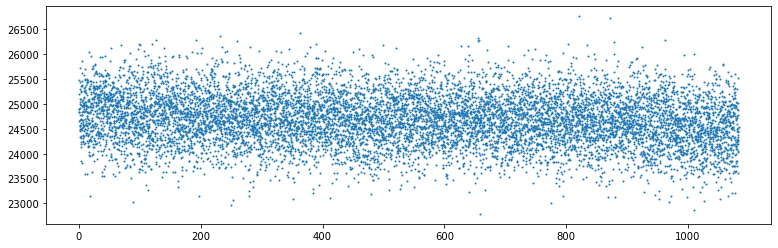

time: 203 ms (started: 2022-03-03 20:49:21 -05:00)


In [210]:
plt.figure(figsize=(13,4))
plt.plot(rate_times, rate_stats, 'o', ms=1)
plt.show()

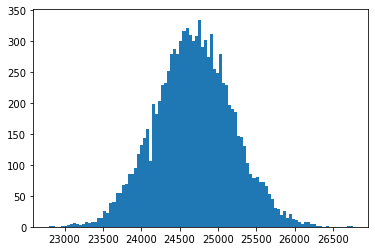

time: 453 ms (started: 2022-03-03 20:50:06 -05:00)


In [211]:
plt.figure()
plt.hist(rate_stats,100)
plt.show()

In [214]:
pharp.close()

PicoHarp300:
Picoharp is DISCONNECTED.

time: 0 ns (started: 2022-03-04 09:34:24 -05:00)


In [ ]:
with h5py.File(os.path.join(data_dir, 'S20B-YAG-single-spot-rates.h5')) as h5file:
    h5file.create_dataset('rates', data = rate_stats)
    h5file.create_dataset('times', data = rate_times)

# Grid Scan (Mar 2) at @ microz 02

In [ ]:
delta = 0.1
scan_params = {'scan_name': 'PLE scan sample 20B',
        'polarization': 'unknown',
        'roi': {'xi': -0.010+delta,
                'xf': 0.000+delta, 
                'yi': -0.010+delta,
                'yf': 0.000+delta},
        'optics': {'obj': '60X/0.95: Olympus',
          'laser_filter':'FF01-543/22',
          'dichroic_mirror':'LPD01 532RS 25',
          'emission_filter':'LP03 532RS',
          'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 300/1000.},
        'velx': 0.04, # may be changed by recording tables consideration
        'dx': 0.2e-3,
        'fast_runway': True,
        'vsafe': 0.2,
        'v_cleaning': 0.3,
        'nr': 150,
        'SNR': 5,
        'stage_trigger_cycles': int(4),
        'cleaning_run': True,
        'scans': []
}
try:
    stage.RTR(scan_params['stage_trigger_cycles'])
except:
    print("Problem setting the trigger cycles, retrying...")
    stage.RTR(scan_params['stage_trigger_cycles'])
scan_params['stage_record_length_in_ms'] = scan_params['stage_trigger_cycles']*50/1000.*8192

print("Opening the laser shutter...")
laser.set_shutter(1)
print("Setting the laser power to %.1f mW..." % (1000*scan_params['laser']['nominal_power_in_W']))
laser.set_power(scan_params['laser']['nominal_power_in_W'])

roi = scan_params['roi']
print("Configuring scan...")
scan = {'sample_name': '%s' % (scan_params['scan_name']),
    'velx': scan_params['velx'], # in mm/s (if not given, then computed from SNR)
    'xi': roi['xi'], # in mm
    'xf': roi['xf'], # in mm
    'yi': roi['yi'], # in mm
    'yf': roi['yf'], # in mm
    'fast_runway': scan_params['fast_runway'], # this controls how the runway is calculated
    'dx': scan_params['dx'], # trigger step
    'vsafe': scan_params['vsafe'], # in mm/s; used to move to the leftmost column
    'v_cleaning': scan_params['v_cleaning'], # in mm/s; used for the cleaning run
    'nr': scan_params['nr'], # dark count rate for the photodetector
    'SNR': scan_params['SNR'], # target SNR
    'cleaning_run': scan_params['cleaning_run']}
scan['e'] = 1.5*compute_runway(stage, scan['velx'], fast = scan_params['fast_runway'])
# computing the estimated linescan time
aprox_linescan_time = (scan['xf']-scan['xi']+scan['e'])/scan['velx']*1000.
if aprox_linescan_time > 0.9*scan_params['stage_record_length_in_ms']:
    print("Record table will run short, increasing scan speed...")
    scan['velx'] = 1000*1.1*(scan['xf']-scan['xi']+scan['e']) / scan_params['stage_record_length_in_ms']

print("scanning...")
scan = T2scanner(stage, pharp, scan)
time_finished = int(time())
scan['time_finished'] = time_finished
print("plotting...")
scan['pdf_fname'] = '%s - %d.pdf' % (scan['sample_name'], time_finished)
scan['png_fname'] = '%s - %d.png' % (scan['sample_name'], time_finished)
scan['jpg_fname'] = '%s - %d.jpg' % (scan['sample_name'], time_finished)
scan['pkl_fname'] = '%s - %d.pkl' % (scan['sample_name'], time_finished)

buf = io.BytesIO()
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(7.2, 6.0))
ims = ax1.imshow(scan['final_map'], origin='lower',
            extent=[scan['xf'],scan['xi'],
                    scan['yi'], scan['yf']],
            cmap='magma', interpolation='none')
ax1.set_xlabel('x/mm')
ax1.set_ylabel('y/mm')
cbar = fig.colorbar(ims,ax=ax1, pad=0.05)
cbar.ax.set_title('kcps')
ax1.set_title(scan['info_title'])
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,scan['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,scan['png_fname']),
            transparent=False)
plt.savefig(buf, format='jpg')
buf.seek(0)
_ = post_file_to_slack(scan['info_title'],
                        scan['jpg_fname'],
                        buf.read(), 
                        slack_channel='#confock')
send_image(os.path.join(graphs_dir,scan['png_fname']), scan['png_fname'])
plt.show()

scan_params['scans'].append(scan)
print("Pickling for keeps...")
pickle.dump(scan_params,
            open(os.path.join(confocal_dir, scan['pkl_fname']),'wb'))
print(os.path.join(confocal_dir, scan['pkl_fname']))
print("Closing the laser shutter...")
laser.set_shutter(0)
send_message("All finished!")

In [ ]:
delta = -0.1
scan_params = {'scan_name': 'PLE scan sample 20B',
        'polarization': 'unknown',
        'roi': {'xi': -0.010+delta,
                'xf': 0.000+delta, 
                'yi': -0.010+delta,
                'yf': 0.000+delta},
        'optics': {'obj': '60X/0.95: Olympus',
          'laser_filter':'FF01-543/22',
          'dichroic_mirror':'LPD01 532RS 25',
          'emission_filter':'LP03 532RS',
          'emission_filter_2':''},
        'laser':{'wavelength': 532,
        'nominal_power_in_W': 300/1000.},
        'velx': 0.04, # may be changed by recording tables consideration
        'dx': 0.2e-3,
        'fast_runway': True,
        'vsafe': 0.2,
        'v_cleaning': 0.3,
        'nr': 150,
        'SNR': 5,
        'stage_trigger_cycles': int(4),
        'cleaning_run': True,
        'scans': []
}
try:
    stage.RTR(scan_params['stage_trigger_cycles'])
except:
    print("Problem setting the trigger cycles, retrying...")
    stage.RTR(scan_params['stage_trigger_cycles'])
scan_params['stage_record_length_in_ms'] = scan_params['stage_trigger_cycles']*50/1000.*8192

print("Opening the laser shutter...")
laser.set_shutter(1)
print("Setting the laser power to %.1f mW..." % (1000*scan_params['laser']['nominal_power_in_W']))
laser.set_power(scan_params['laser']['nominal_power_in_W'])

roi = scan_params['roi']
print("Configuring scan...")
scan = {'sample_name': '%s' % (scan_params['scan_name']),
    'velx': scan_params['velx'], # in mm/s (if not given, then computed from SNR)
    'xi': roi['xi'], # in mm
    'xf': roi['xf'], # in mm
    'yi': roi['yi'], # in mm
    'yf': roi['yf'], # in mm
    'fast_runway': scan_params['fast_runway'], # this controls how the runway is calculated
    'dx': scan_params['dx'], # trigger step
    'vsafe': scan_params['vsafe'], # in mm/s; used to move to the leftmost column
    'v_cleaning': scan_params['v_cleaning'], # in mm/s; used for the cleaning run
    'nr': scan_params['nr'], # dark count rate for the photodetector
    'SNR': scan_params['SNR'], # target SNR
    'cleaning_run': scan_params['cleaning_run']}
scan['e'] = 1.5*compute_runway(stage, scan['velx'], fast = scan_params['fast_runway'])
# computing the estimated linescan time
aprox_linescan_time = (scan['xf']-scan['xi']+scan['e'])/scan['velx']*1000.
if aprox_linescan_time > 0.9*scan_params['stage_record_length_in_ms']:
    print("Record table will run short, increasing scan speed...")
    scan['velx'] = 1000*1.1*(scan['xf']-scan['xi']+scan['e']) / scan_params['stage_record_length_in_ms']

print("scanning...")
scan = T2scanner(stage, pharp, scan)
time_finished = int(time())
scan['time_finished'] = time_finished
print("plotting...")
scan['pdf_fname'] = '%s - %d.pdf' % (scan['sample_name'], time_finished)
scan['png_fname'] = '%s - %d.png' % (scan['sample_name'], time_finished)
scan['jpg_fname'] = '%s - %d.jpg' % (scan['sample_name'], time_finished)
scan['pkl_fname'] = '%s - %d.pkl' % (scan['sample_name'], time_finished)

buf = io.BytesIO()
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(7.2, 6.0))
ims = ax1.imshow(scan['final_map'], origin='lower',
            extent=[scan['xf'],scan['xi'],
                    scan['yi'], scan['yf']],
            cmap='magma', interpolation='none')
ax1.set_xlabel('x/mm')
ax1.set_ylabel('y/mm')
cbar = fig.colorbar(ims,ax=ax1, pad=0.05)
cbar.ax.set_title('kcps')
ax1.set_title(scan['info_title'])
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir,scan['pdf_fname']),
            transparent=True)
plt.savefig(os.path.join(graphs_dir,scan['png_fname']),
            transparent=False)
plt.savefig(buf, format='jpg')
buf.seek(0)
_ = post_file_to_slack(scan['info_title'],
                        scan['jpg_fname'],
                        buf.read(), 
                        slack_channel='#confock')
send_image(os.path.join(graphs_dir,scan['png_fname']), scan['png_fname'])
plt.show()

scan_params['scans'].append(scan)
print("Pickling for keeps...")
pickle.dump(scan_params,
            open(os.path.join(confocal_dir, scan['pkl_fname']),'wb'))
print(os.path.join(confocal_dir, scan['pkl_fname']))
print("Closing the laser shutter...")
laser.set_shutter(0)
send_message("All finished!")

In [ ]:
reps = 4
d = 0.01
bigscan = {'deltaxs': [d*rep for rep in range(reps)]}
bigscan['deltays'] = bigscan['deltaxs']
bigscan['d'] = d
bigscan['scans'] = {}
d = bigscan['d']
for deltay in bigscan['deltays']:
    for deltax in bigscan['deltaxs']:
        print("scanning", deltax, deltay)
        scan_params = {'scan_name': 'PLE scan sample 20B',
                'polarization': 'unknown',
                'roi': {'xi': -d + deltax,
                        'xf': 0.000 + deltax, 
                        'yi': -d + deltay,
                        'yf': 0.000 + deltay},
                'optics': {'obj': '60X/0.95: Olympus',
                'laser_filter':'FF01-543/22',
                'dichroic_mirror':'LPD01 532RS 25',
                'emission_filter':'LP03 532RS',
                'emission_filter_2':''},
                'laser':{'wavelength': 532,
                'nominal_power_in_W': 300/1000.},
                'velx': 0.04, # may be changed by recording tables consideration
                'dx': 0.2e-3,
                'fast_runway': True,
                'vsafe': 0.2,
                'v_cleaning': 0.3,
                'nr': 150,
                'SNR': 5,
                'stage_trigger_cycles': int(4),
                'cleaning_run': True,
                'scans': []
        }
        try:
            stage.RTR(scan_params['stage_trigger_cycles'])
        except:
            print("Problem setting the trigger cycles, retrying...")
            stage.RTR(scan_params['stage_trigger_cycles'])
        scan_params['stage_record_length_in_ms'] = scan_params['stage_trigger_cycles']*50/1000.*8192

        print("Opening the laser shutter...")
        laser.set_shutter(1)
        print("Setting the laser power to %.1f mW..." % (1000*scan_params['laser']['nominal_power_in_W']))
        laser.set_power(scan_params['laser']['nominal_power_in_W'])

        roi = scan_params['roi']
        print("Configuring scan...")
        scan = {'sample_name': '%s' % (scan_params['scan_name']),
            'velx': scan_params['velx'], # in mm/s (if not given, then computed from SNR)
            'xi': roi['xi'], # in mm
            'xf': roi['xf'], # in mm
            'yi': roi['yi'], # in mm
            'yf': roi['yf'], # in mm
            'fast_runway': scan_params['fast_runway'], # this controls how the runway is calculated
            'dx': scan_params['dx'], # trigger step
            'vsafe': scan_params['vsafe'], # in mm/s; used to move to the leftmost column
            'v_cleaning': scan_params['v_cleaning'], # in mm/s; used for the cleaning run
            'nr': scan_params['nr'], # dark count rate for the photodetector
            'SNR': scan_params['SNR'], # target SNR
            'cleaning_run': scan_params['cleaning_run']}
        scan['e'] = 1.5*compute_runway(stage, scan['velx'], fast = scan_params['fast_runway'])
        # computing the estimated linescan time
        aprox_linescan_time = (scan['xf']-scan['xi']+scan['e'])/scan['velx']*1000.
        if aprox_linescan_time > 0.9*scan_params['stage_record_length_in_ms']:
            print("Record table will run short, increasing scan speed...")
            scan['velx'] = 1000*1.1*(scan['xf']-scan['xi']+scan['e']) / scan_params['stage_record_length_in_ms']

        print("scanning...")
        scan = T2scanner(stage, pharp, scan)
        time_finished = int(time())
        scan['time_finished'] = time_finished
        print("plotting...")
        scan['pdf_fname'] = '%s - %d.pdf' % (scan['sample_name'], time_finished)
        scan['png_fname'] = '%s - %d.png' % (scan['sample_name'], time_finished)
        scan['jpg_fname'] = '%s - %d.jpg' % (scan['sample_name'], time_finished)
        scan['pkl_fname'] = '%s - %d.pkl' % (scan['sample_name'], time_finished)

        buf = io.BytesIO()
        fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(7.2, 6.0))
        ims = ax1.imshow(scan['final_map'], origin='lower',
                    extent=[scan['xf'],scan['xi'],
                            scan['yi'], scan['yf']],
                    cmap='magma', interpolation='none')
        ax1.set_xlabel('x/mm')
        ax1.set_ylabel('y/mm')
        cbar = fig.colorbar(ims,ax=ax1, pad=0.05)
        cbar.ax.set_title('kcps')
        ax1.set_title(scan['info_title'])
        plt.tight_layout()
        plt.savefig(os.path.join(graphs_dir,scan['pdf_fname']),
                    transparent=True)
        plt.savefig(os.path.join(graphs_dir,scan['png_fname']),
                    transparent=False)
        plt.savefig(buf, format='jpg')
        buf.seek(0)
        _ = post_file_to_slack(scan['info_title'],
                                scan['jpg_fname'],
                                buf.read(), 
                                slack_channel='#confock')
        send_image(os.path.join(graphs_dir,scan['png_fname']), scan['png_fname'])
        plt.show()

        scan_params['scans'].append(scan)
        print("Pickling for keeps...")
        pickle.dump(scan_params,
                    open(os.path.join(confocal_dir, scan['pkl_fname']),'wb'))
        print(os.path.join(confocal_dir, scan['pkl_fname']))
        print("Closing the laser shutter...")
        laser.set_shutter(0)
        bigscan['scans'][(deltax, deltay)] = scan_params
    send_message("Big row finished.")
bigscan['time_finished'] = int(time())
bigscan['pkl_fname'] = '%s - gridscan - %d.pkl' % (scan['sample_name'], bigscan['time_finished'])
pickle.dump(bigscan, open(os.path.join(confocal_dir, bigscan['pkl_fname']),'wb'))


In [63]:
print(bigscan['pkl_fname'])

PLE scan sample 20B - gridscan - 1646253468.pkl
time: 16 ms (started: 2022-03-02 15:49:29 -05:00)


In [109]:
all_dwell_times = []
for linescan in bigscan['scans'][(0,0)]['scans'][0]['linescans']:
    clicks = (linescan['events'])*4./1e9
    position_marks = (linescan['bintimes'])*4/1e9
    position_marks = position_marks - position_marks[0]
    stage_times =  (linescan['trajectory']['times'])
    stage_dt = stage_times[1]-stage_times[0] # in ms
    stage_positions = (linescan['trajectory']['actual_positions'])
    for stage_time_pivot in stage_positions:
        if stage_time_pivot >= linescan['xi']:
            break
    stage_times = stage_times - stage_time_pivot
    interpol_clicks = np.interp(clicks, stage_times, stage_positions)
    linescan_marks = np.arange(linescan['xi'], linescan['xf'], linescan['dx'])
    better_counts, _ = np.histogram(interpol_clicks, linescan_marks)
    dwell_times, _ = np.histogram(stage_positions, bins= linescan_marks)
    all_dwell_times.append(stage_dt*dwell_times)
mean_dwell_in_ms = np.mean(np.array(all_dwell_times).flatten())

time: 31 ms (started: 2022-03-02 16:07:32 -05:00)


In [ ]:
grid = []
for y_idx, deltay in enumerate(bigscan['deltays']):
    row = []
    for x_idx, deltax in enumerate(bigscan['deltaxs']):
        if x_idx == 1:
            continue
        final_map = bigscan['scans'][(deltax, deltay)]['scans'][0]['final_map_simple']
        row.append(final_map[:50,:35])
    grid.append(np.concatenate(row))
grid = np.concatenate(grid,axis=1)
grid = grid*mean_dwell_in_ms
plt.figure(figsize=(10,10))
plt.imshow(grid,origin='lower',
                    extent=[0,1000*bigscan['d']*reps,
                            0,1000*bigscan['d']*reps],
                    cmap='magma', interpolation='none')
plt.xlabel('x/um')
plt.ylabel('y/um')
plt.colorbar()
plt.show()


In [136]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson

time: 15 ms (started: 2022-03-02 16:53:15 -05:00)


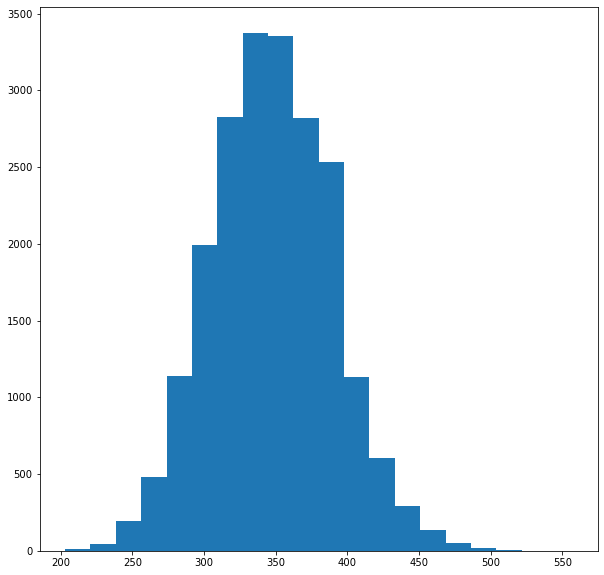

time: 235 ms (started: 2022-03-02 16:53:17 -05:00)


In [137]:
plt.figure(figsize=(10,10))
plt.hist(grid.flatten().astype(np.int32), bins=20)
plt.show()

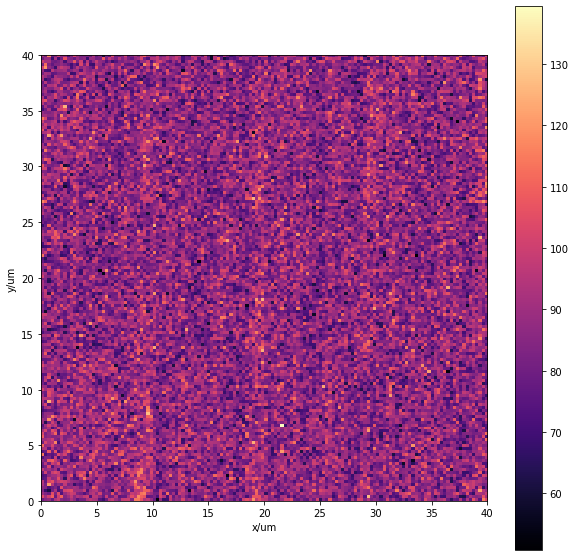

time: 375 ms (started: 2022-03-02 17:16:17 -05:00)


In [142]:
plt.figure(figsize=(10,10))
plt.imshow(grid/4.,origin='lower',
                    extent=[0,1000*bigscan['d']*reps,
                            0,1000*bigscan['d']*reps],
                    cmap='magma', interpolation='none')
plt.xlabel('x/um')
plt.ylabel('y/um')a
plt.colorbar()
plt.show()

In [141]:
# import h5py
# with h5py.File(os.path.join(data_dir, 'S20B-YAG-gridscan-1-nointerpol.h5')) as h5file:
#     h5file.create_dataset('griddata', data = grid.astype(np.int32))

time: 32 ms (started: 2022-03-02 16:54:07 -05:00)


<ipython-input-141-634de469e39b>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(data_dir, 'S20B-YAG-gridscan-1-nointerpol.h5')) as h5file:


In [ ]:
v

# Debug Scans (Mar 1) at uz 02